# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

X1           X2           X3           X4           X5  \
count  7845.000000  7845.000000  7845.000000  7845.000000  7845.000000   
mean      0.333764     0.200042     0.251736     0.365734     0.160780   
std       1.025813     1.136427     1.101461     0.988616     1.157123   
min      -0.784415    -0.452501    -0.591631    -0.859553    -0.377866   
25%      -0.145333    -0.408265    -0.276061    -0.859553    -0.377866   
50%       0.111790    -0.271133    -0.005571     0.550163    -0.377866   
75%       0.508993     0.219887     0.400163     1.027382     0.387549   
max      31.508443     5.085849    29.477769     9.591164    23.617122   

                X6        CLASS  
count  7845.000000  7845.000000  
mean      0.402400     0.032250  
std       0.939678     0.176674  
min      -0.945723     0.000000  
25%      -0.945723     0.000000  
50%       0.845975     0.000000  
75%       1.132403     0.000000  
max       1.949027     1.000000

### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def centroid_undersampling(data):
    '''Faz o undersampling pegando as amostras do centro do cluster
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    centrounder = ClusterCentroids(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = centrounder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = centrounder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = centroid_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 126, 0.0: 126})
Counter({1.0: 63, 0.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [33]:
learnRate = 0.001
graficoName = "kmedias, lr=0.001, rede="

## RNA 1 (10)

In [34]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4123 - acc: 0.5119 - val_loss: 0.7266 - val_acc: 0.5238
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4064 - acc: 0.5198 - val_loss: 0.7165 - val_acc: 0.5238
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.4002 - acc: 0.5198 - val_loss: 0.7060 - val_acc: 0.5238
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3932 - acc: 0.5198 - val_loss: 0.6949 - val_acc: 0.5238
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.3854 - acc: 0.5278 - val_loss: 0.6837 - val_acc: 0.5317
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.3770 - acc: 0.5278 - val_loss: 0.6722 - val_acc: 0.5397
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.3678 - acc: 0.5278 - val_loss: 0.6612 - val_acc: 0.5397
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.1289 - acc: 0.8452 - val_loss: 0.3395 - val_acc: 0.8413
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.1283 - acc: 0.8492 - val_loss: 0.3376 - val_acc: 0.8413
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.1276 - acc: 0.8492 - val_loss: 0.3357 - val_acc: 0.8413
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.1270 - acc: 0.8492 - val_loss: 0.3339 - val_acc: 0.8413
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.1263 - acc: 0.8532 - val_loss: 0.3320 - val_acc: 0.8413
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.1257 - acc: 0.8532 - val_loss: 0.3302 - val_acc: 0.8413
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.1252 - acc: 0.8532 - val_loss: 0.3285 - val_acc: 0.8413
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.1247 - acc: 0.8532 - val_loss: 0.3268 - val_acc:

252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8532 - val_loss: 0.2652 - val_acc: 0.8333
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8532 - val_loss: 0.2645 - val_acc: 0.8333
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8532 - val_loss: 0.2637 - val_acc: 0.8333
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8532 - val_loss: 0.2631 - val_acc: 0.8333
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1109 - acc: 0.8532 - val_loss: 0.2624 - val_acc: 0.8333
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1108 - acc: 0.8571 - val_loss: 0.2617 - val_acc: 0.8333
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1107 - acc: 0.8571 - val_loss: 0.2610 - val_acc: 0.8333
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1106 - acc: 0.8571 - val_loss: 0.2604 - v

252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8571 - val_loss: 0.2328 - val_acc: 0.8333
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1067 - acc: 0.8571 - val_loss: 0.2324 - val_acc: 0.8333
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1067 - acc: 0.8571 - val_loss: 0.2321 - val_acc: 0.8333
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.2317 - val_acc: 0.8333
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.2314 - val_acc: 0.8333
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.2311 - val_acc: 0.8333
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8611 - val_loss: 0.2307 - val_acc: 0.8333
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8611 - val_loss: 0.2303 - v

252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8770 - val_loss: 0.2164 - val_acc: 0.8333
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2161 - val_acc: 0.8333
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2160 - val_acc: 0.8333
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2157 - val_acc: 0.8333
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2155 - val_acc: 0.8333
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8770 - val_loss: 0.2153 - val_acc: 0.8333
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8770 - val_loss: 0.2151 - val_acc: 0.8333
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8770 - val_loss: 0.2149 - v

252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8730 - val_loss: 0.2062 - val_acc: 0.8413
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8730 - val_loss: 0.2061 - val_acc: 0.8413
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8730 - val_loss: 0.2061 - val_acc: 0.8413
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8730 - val_loss: 0.2060 - val_acc: 0.8413
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8730 - val_loss: 0.2058 - val_acc: 0.8413
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8730 - val_loss: 0.2057 - val_acc: 0.8413
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8730 - val_loss: 0.2056 - val_acc: 0.8413
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8730 - val_loss: 0.2055 - v

252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1998 - val_acc: 0.8413
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1997 - val_acc: 0.8413
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1996 - val_acc: 0.8413
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1995 - val_acc: 0.8413
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1994 - val_acc: 0.8413
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1992 - val_acc: 0.8413
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1991 - val_acc: 0.8413
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1991 - v

252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1954 - val_acc: 0.8413
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1954 - val_acc: 0.8413
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8730 - val_loss: 0.1953 - val_acc: 0.8413
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8730 - val_loss: 0.1952 - val_acc: 0.8413
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8730 - val_loss: 0.1952 - val_acc: 0.8413
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8730 - val_loss: 0.1952 - val_acc: 0.8413
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8730 - val_loss: 0.1951 - val_acc: 0.8413
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8730 - val_loss: 0.1950 - v

252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1922 - val_acc: 0.8413
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1922 - val_acc: 0.8413
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1922 - val_acc: 0.8413
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1921 - val_acc: 0.8413
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1920 - val_acc: 0.8413
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1920 - val_acc: 0.8413
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8730 - val_loss: 0.1920 - val_acc: 0.8413
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8730 - val_loss: 0.1920 - v

252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8730 - val_loss: 0.1895 - val_acc: 0.8413
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8730 - val_loss: 0.1895 - val_acc: 0.8413
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8730 - val_loss: 0.1894 - val_acc: 0.8413
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8730 - val_loss: 0.1894 - val_acc: 0.8413
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1894 - val_acc: 0.8413
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1893 - val_acc: 0.8492
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1892 - val_acc: 0.8492
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1892 - v

252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1870 - val_acc: 0.8492
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1870 - val_acc: 0.8492
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8690 - val_loss: 0.1868 - val_acc: 0.8492
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1867 - v

252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8690 - val_loss: 0.1846 - val_acc: 0.8492
Epoch 694/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8690 - val_loss: 0.1846 - val_acc: 0.8492
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8690 - val_loss: 0.1845 - val_acc: 0.8492
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8690 - val_loss: 0.1844 - val_acc: 0.8492
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8690 - val_loss: 0.1844 - val_acc: 0.8492
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8690 - val_loss: 0.1843 - val_acc: 0.8492
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8651 - val_loss: 0.1843 - val_acc: 0.8492
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8690 - val_loss: 0.1843 - v

252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1822 - val_acc: 0.8492
Epoch 757/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1822 - val_acc: 0.8492
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1821 - val_acc: 0.8492
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1821 - val_acc: 0.8492
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1820 - val_acc: 0.8492
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1820 - val_acc: 0.8492
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1820 - val_acc: 0.8492
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1819 - v

252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8651 - val_loss: 0.1800 - val_acc: 0.8571
Epoch 820/100000
252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8651 - val_loss: 0.1799 - val_acc: 0.8571
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8651 - val_loss: 0.1799 - val_acc: 0.8571
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8651 - val_loss: 0.1798 - val_acc: 0.8651
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8651 - val_loss: 0.1797 - val_acc: 0.8651
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8651 - val_loss: 0.1797 - val_acc: 0.8651
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8651 - val_loss: 0.1797 - val_acc: 0.8651
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8651 - val_loss: 0.1796 - v

252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8730 - val_loss: 0.1776 - val_acc: 0.8651
Epoch 883/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8730 - val_loss: 0.1776 - val_acc: 0.8651
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1776 - val_acc: 0.8651
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1775 - val_acc: 0.8651
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1775 - val_acc: 0.8651
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1774 - val_acc: 0.8651
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1774 - val_acc: 0.8651
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1773 - v

252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8770 - val_loss: 0.1751 - val_acc: 0.8651
Epoch 946/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8770 - val_loss: 0.1750 - val_acc: 0.8651
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8770 - val_loss: 0.1750 - val_acc: 0.8651
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8810 - val_loss: 0.1750 - val_acc: 0.8651
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8770 - val_loss: 0.1749 - val_acc: 0.8651
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8770 - val_loss: 0.1748 - val_acc: 0.8651
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8770 - val_loss: 0.1748 - val_acc: 0.8651
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8770 - val_loss: 0.1747 - v

252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1725 - val_acc: 0.8730
Epoch 1009/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1723 - val_acc: 0.8730
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8770 - val_loss: 0.1704 - val_acc: 0.8730
Epoch 1071/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8770 - val_loss: 0.1704 - val_acc: 0.8730
Epoch 1072/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1703 - val_acc: 0.8730
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1704 - val_acc: 0.8730
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1704 - val_acc: 0.8730
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1703 - val_acc: 0.8730
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1703 - val_acc: 0.8730
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8770 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1134/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1135/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1669 - val_acc: 0.8889
Epoch 1197/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1668 - val_acc: 0.8889
Epoch 1198/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1668 - val_acc: 0.8889
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1667 - val_acc: 0.8889
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1668 - val_acc: 0.8889
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1668 - val_acc: 0.8889
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1668 - val_acc: 0.8889
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1651 - val_acc: 0.8889
Epoch 1260/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1650 - val_acc: 0.8889
Epoch 1261/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1649 - val_acc: 0.8889
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1649 - val_acc: 0.8889
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1649 - val_acc: 0.8889
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1648 - val_acc: 0.8889
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8849 - val_loss: 0.1648 - val_acc: 0.8889
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1631 - val_acc: 0.8889
Epoch 1323/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1631 - val_acc: 0.8889
Epoch 1324/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1631 - val_acc: 0.8889
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1631 - val_acc: 0.8889
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1631 - val_acc: 0.8889
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1631 - val_acc: 0.8889
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1631 - val_acc: 0.8889
Epoch 1329/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8849 - val_loss: 0.1616 - val_acc: 0.8889
Epoch 1386/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1616 - val_acc: 0.8889
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8849 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8810 - val_loss: 0.1614 - val_acc: 0.8889
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1597 - val_acc: 0.8889
Epoch 1449/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1597 - val_acc: 0.8889
Epoch 1450/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1597 - val_acc: 0.8889
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.0928 - acc: 0.8810 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1454/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1595 - val_acc: 0.8889
Epoch 1455/100000
252/252 [==============================] - 0s - loss: 0.0928 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1578 - val_acc: 0.8889
Epoch 1512/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8810 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8810 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8889
Epoch 1575/100000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8889
Epoch 1576/100000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8889
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8849 - val_loss: 0.1556 - val_acc: 0.8889
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1556 - val_acc: 0.8889
Epoch 1579/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1556 - val_acc: 0.8810
Epoch 1580/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1556 - val_acc: 0.8810
Epoch 1581/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1637/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8889 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8889 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1527 - val_acc: 0.8810
Epoch 1699/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1527 - val_acc: 0.8810
Epoch 1700/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1526 - val_acc: 0.8810
Epoch 1701/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1526 - val_acc: 0.8810
Epoch 1702/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1526 - val_acc: 0.8810
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1525 - val_acc: 0.8810
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1525 - val_acc: 0.8810
Epoch 1705/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1513 - val_acc: 0.8810
Epoch 1762/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1763/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1513 - val_acc: 0.8810
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1513 - val_acc: 0.8810
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1501 - val_acc: 0.8810
Epoch 1825/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1501 - val_acc: 0.8810
Epoch 1826/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1501 - val_acc: 0.8810
Epoch 1827/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1501 - val_acc: 0.8810
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1501 - val_acc: 0.8810
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1500 - val_acc: 0.8810
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1500 - val_acc: 0.8810
Epoch 1831/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1887/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1888/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1889/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1891/100000
252/252 [==============================] - ETA: 0s - loss: 0.1206 - acc: 0.875 - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1893/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1478 - val_acc: 0.8810
Epoch 1949/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1478 - val_acc: 0.8810
Epoch 1950/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1478 - val_acc: 0.8810
Epoch 1951/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1477 - val_acc: 0.8810
Epoch 1952/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1477 - val_acc: 0.8810
Epoch 1953/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1477 - val_acc: 0.8810
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1477 - val_acc: 0.8810
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1468 - val_acc: 0.8810
Epoch 2012/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2013/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2014/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1466 - val_acc: 0.8810
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8889 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 2075/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8889 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 2076/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8889 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 2077/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8889 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 2078/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8889 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 2079/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8889 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 2080/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8889 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1459 - val_acc: 0.8810
Epoch 2138/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1459 - val_acc: 0.8810
Epoch 2139/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2140/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8889 - val_loss: 0.1453 - val_acc: 0.8810
Epoch 2201/100000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8810
Epoch 2202/100000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8810
Epoch 2203/100000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8810
Epoch 2204/100000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8810
Epoch 2205/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8810
Epoch 2206/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8810
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2263/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2264/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2265/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2266/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8929 - val_loss: 0.1439 - val_acc: 0.8810
Epoch 2325/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8929 - val_loss: 0.1439 - val_acc: 0.8810
Epoch 2326/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2327/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2328/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2329/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2330/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8929 - val_loss: 0.1437 - val_acc: 0.8810
Epoch 2331/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2388/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2389/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2390/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8810
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8810
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8810
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 2451/100000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 2452/100000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 2453/100000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 2454/100000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 2455/100000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 2456/100000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1424 - val_acc: 0.8810
Epoch 2457/100000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2514/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2515/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2516/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2519/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1412 - val_acc: 0.8810
Epoch 2577/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1411 - val_acc: 0.8810
Epoch 2578/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1411 - val_acc: 0.8810
Epoch 2579/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1411 - val_acc: 0.8810
Epoch 2580/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1411 - val_acc: 0.8810
Epoch 2581/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1411 - val_acc: 0.8810
Epoch 2582/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1411 - val_acc: 0.8810
Epoch 2583/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2640/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1407 - val_acc: 0.8810
Epoch 2641/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2642/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2643/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2644/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2646/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 2703/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 2704/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 2705/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 2706/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 2707/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 2708/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 2709/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2765/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2766/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2767/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2768/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1392 - val_acc: 0.8810
Epoch 2769/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1392 - val_acc: 0.8810
Epoch 2770/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8968 - val_loss: 0.1392 - val_acc: 0.8810
Epoch 2771/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1386 - val_acc: 0.8810
Epoch 2828/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1386 - val_acc: 0.8810
Epoch 2829/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1386 - val_acc: 0.8810
Epoch 2830/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1385 - val_acc: 0.8810
Epoch 2831/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1386 - val_acc: 0.8810
Epoch 2832/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1385 - val_acc: 0.8810
Epoch 2833/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1385 - val_acc: 0.8810
Epoch 2834/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2891/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2892/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2893/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2894/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2895/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2896/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1379 - val_acc: 0.8810
Epoch 2897/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1374 - val_acc: 0.8810
Epoch 2954/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1374 - val_acc: 0.8810
Epoch 2955/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1374 - val_acc: 0.8810
Epoch 2956/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1374 - val_acc: 0.8810
Epoch 2957/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1374 - val_acc: 0.8810
Epoch 2958/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1374 - val_acc: 0.8810
Epoch 2959/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1373 - val_acc: 0.8810
Epoch 2960/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8810
Epoch 3017/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1368 - val_acc: 0.8810
Epoch 3018/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8810
Epoch 3019/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8810
Epoch 3020/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8810
Epoch 3021/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8810
Epoch 3022/100000
252/252 [==============================] - ETA: 0s - loss: 0.1246 - acc: 0.875 - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8810
Epoch 3023/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8810
Epoch 3079/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8810
Epoch 3080/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8810
Epoch 3081/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8810
Epoch 3082/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8810
Epoch 3083/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8810
Epoch 3084/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1359 - val_acc: 0.8810
Epoch 3085/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3142/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1353 - val_acc: 0.8810
Epoch 3143/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1353 - val_acc: 0.8810
Epoch 3144/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3145/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3146/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3147/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3148/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8810
Epoch 3205/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8810
Epoch 3206/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8810
Epoch 3207/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8810
Epoch 3208/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8810
Epoch 3209/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8810
Epoch 3210/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8810
Epoch 3211/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1339 - val_acc: 0.8810
Epoch 3268/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3269/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3270/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3271/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1337 - val_acc: 0.8810
Epoch 3272/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3273/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1337 - val_acc: 0.8810
Epoch 3274/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 3331/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 3332/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 3333/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 3334/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 3335/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 3336/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 3337/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1322 - val_acc: 0.8889
Epoch 3394/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3395/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3396/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3397/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3398/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3399/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3400/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1314 - val_acc: 0.8889
Epoch 3457/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1313 - val_acc: 0.8889
Epoch 3458/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1313 - val_acc: 0.8889
Epoch 3459/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1313 - val_acc: 0.8889
Epoch 3460/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1313 - val_acc: 0.8889
Epoch 3461/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1312 - val_acc: 0.8889
Epoch 3462/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1313 - val_acc: 0.8889
Epoch 3463/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8889
Epoch 3519/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8889
Epoch 3520/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8889
Epoch 3521/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3522/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3523/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3524/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3525/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1299 - val_acc: 0.8889
Epoch 3582/100000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1299 - val_acc: 0.8889
Epoch 3583/100000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1298 - val_acc: 0.8889
Epoch 3584/100000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1298 - val_acc: 0.8889
Epoch 3585/100000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1298 - val_acc: 0.8889
Epoch 3586/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1298 - val_acc: 0.8889
Epoch 3587/100000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1298 - val_acc: 0.8889
Epoch 3588/100000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3644/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3645/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3646/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3647/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3648/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3649/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3650/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.8889
Epoch 3707/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.8889
Epoch 3708/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9087 - val_loss: 0.1284 - val_acc: 0.8889
Epoch 3709/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.8889
Epoch 3710/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.8889
Epoch 3711/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.8889
Epoch 3712/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1283 - val_acc: 0.8889
Epoch 3713/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3770/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1277 - val_acc: 0.8889
Epoch 3771/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1277 - val_acc: 0.8889
Epoch 3772/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3773/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3774/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3775/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3776/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1270 - val_acc: 0.8889
Epoch 3832/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1270 - val_acc: 0.8889
Epoch 3833/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1270 - val_acc: 0.8889
Epoch 3834/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1270 - val_acc: 0.8889
Epoch 3835/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1270 - val_acc: 0.8889
Epoch 3836/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1270 - val_acc: 0.8889
Epoch 3837/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1269 - val_acc: 0.8889
Epoch 3838/100000
252/252 [==============================] - ETA: 0s - loss: 0.1517 - acc: 0.843 - 0s - loss

252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3894/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3895/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3896/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3897/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1262 - val_acc: 0.8889
Epoch 3898/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1262 - val_acc: 0.8889
Epoch 3899/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1262 - val_acc: 0.8889
Epoch 3900/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1255 - val_acc: 0.8889
Epoch 3956/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1255 - val_acc: 0.8889
Epoch 3957/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1255 - val_acc: 0.8889
Epoch 3958/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1255 - val_acc: 0.8889
Epoch 3959/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1255 - val_acc: 0.8889
Epoch 3960/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1255 - val_acc: 0.8889
Epoch 3961/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1255 - val_acc: 0.8889
Epoch 3962/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4019/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4020/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4021/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4022/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8889
Epoch 4023/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8889
Epoch 4024/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8889
Epoch 4025/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1242 - val_acc: 0.8889
Epoch 4082/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8889
Epoch 4083/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8889
Epoch 4084/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8889
Epoch 4085/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8889
Epoch 4086/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8889
Epoch 4087/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8889
Epoch 4088/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4144/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4145/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4146/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4147/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1232 - val_acc: 0.8889
Epoch 4148/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4149/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1232 - val_acc: 0.8889
Epoch 4150/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8889
Epoch 4207/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8889
Epoch 4208/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8889
Epoch 4209/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1225 - val_acc: 0.8889
Epoch 4210/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1225 - val_acc: 0.8889
Epoch 4211/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8889
Epoch 4212/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1225 - val_acc: 0.8889
Epoch 4213/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4270/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4271/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4272/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4273/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1217 - val_acc: 0.8889
Epoch 4274/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4275/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1217 - val_acc: 0.8889
Epoch 4276/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8889
Epoch 4333/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8889
Epoch 4334/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1210 - val_acc: 0.8889
Epoch 4335/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1210 - val_acc: 0.8889
Epoch 4336/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1210 - val_acc: 0.8889
Epoch 4337/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1210 - val_acc: 0.8889
Epoch 4338/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1210 - val_acc: 0.8889
Epoch 4339/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4395/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4396/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4397/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4398/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4399/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4400/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1203 - val_acc: 0.8889
Epoch 4401/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1197 - val_acc: 0.8889
Epoch 4458/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8889
Epoch 4459/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1197 - val_acc: 0.8889
Epoch 4460/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1197 - val_acc: 0.8889
Epoch 4461/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1197 - val_acc: 0.8889
Epoch 4462/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1197 - val_acc: 0.8889
Epoch 4463/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1197 - val_acc: 0.8889
Epoch 4464/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1191 - val_acc: 0.8889
Epoch 4521/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9008 - val_loss: 0.1191 - val_acc: 0.8889
Epoch 4522/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8889
Epoch 4523/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8889
Epoch 4524/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1189 - val_acc: 0.8889
Epoch 4525/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1189 - val_acc: 0.8889
Epoch 4526/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8889
Epoch 4527/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8889
Epoch 4584/100000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8889
Epoch 4585/100000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8889
Epoch 4586/100000
252/252 [==============================] - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.8889
Epoch 4587/100000
252/252 [==============================] - ETA: 0s - loss: 0.0855 - acc: 0.906 - 0s - loss: 0.0825 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8889
Epoch 4588/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8889
Epoch 4589/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8889
Epoch 4590/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1178 - val_acc: 0.8889
Epoch 4646/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1178 - val_acc: 0.8889
Epoch 4647/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4648/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4649/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4650/100000
252/252 [==============================] - ETA: 0s - loss: 0.1010 - acc: 0.875 - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4651/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4652/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9008 - val_loss: 0.1172 - val_acc: 0.8889
Epoch 4708/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8889
Epoch 4709/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8889
Epoch 4710/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8889
Epoch 4711/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8889
Epoch 4712/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8889
Epoch 4713/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8889
Epoch 4714/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4771/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4772/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4773/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4774/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4775/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4776/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4777/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1160 - val_acc: 0.8889
Epoch 4834/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1160 - val_acc: 0.8889
Epoch 4835/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1160 - val_acc: 0.8889
Epoch 4836/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8889
Epoch 4837/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8889
Epoch 4838/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8889
Epoch 4839/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8889
Epoch 4840/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4897/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4898/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4899/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4900/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8889
Epoch 4901/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4902/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8889
Epoch 4903/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 4960/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1148 - val_acc: 0.8889
Epoch 4961/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1148 - val_acc: 0.8889
Epoch 4962/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1148 - val_acc: 0.8889
Epoch 4963/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1148 - val_acc: 0.8889
Epoch 4964/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1148 - val_acc: 0.8889
Epoch 4965/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1148 - val_acc: 0.8889
Epoch 4966/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 5022/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5023/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5024/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5025/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5026/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 5027/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5028/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 5085/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 5086/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 5087/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 5088/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 5089/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 5090/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8889
Epoch 5091/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1132 - val_acc: 0.8889
Epoch 5148/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1132 - val_acc: 0.8889
Epoch 5149/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5150/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5151/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5152/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5153/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5154/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 5210/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 5211/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 5212/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 5213/100000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 5214/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 5215/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8889
Epoch 5216/100000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5273/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5274/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5275/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5276/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5277/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5278/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5279/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 5336/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1111 - val_acc: 0.8889
Epoch 5337/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 5338/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 5339/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 5340/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 5341/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1110 - val_acc: 0.8889
Epoch 5342/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5398/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5399/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5400/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5401/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5402/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5403/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5404/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1098 - val_acc: 0.8889
Epoch 5461/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 5462/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 5463/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 5464/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 5465/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 5466/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 5467/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5523/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5524/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5525/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5526/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5527/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5528/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5529/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1092 - val_acc: 0.8889
Epoch 5586/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1092 - val_acc: 0.8889
Epoch 5587/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1092 - val_acc: 0.8889
Epoch 5588/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1092 - val_acc: 0.8889
Epoch 5589/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1092 - val_acc: 0.8889
Epoch 5590/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1092 - val_acc: 0.8889
Epoch 5591/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1092 - val_acc: 0.8889
Epoch 5592/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5649/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5650/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5651/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5652/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5653/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5654/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5655/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 5712/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 5713/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 5714/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 5715/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 5716/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 5717/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1084 - val_acc: 0.8889
Epoch 5718/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5775/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5776/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5777/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5778/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5779/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5780/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5781/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 5838/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 5839/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 5840/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 5841/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 5842/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 5843/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 5844/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5900/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5901/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5902/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5903/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5904/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5905/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5906/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 5962/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 5963/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 5964/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 5965/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 5966/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 5967/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 5968/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6024/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6025/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6026/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6027/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6028/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6029/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1066 - val_acc: 0.8968
Epoch 6030/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8968
Epoch 6087/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8968
Epoch 6088/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8968
Epoch 6089/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8968
Epoch 6090/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8968
Epoch 6091/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8968
Epoch 6092/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8968
Epoch 6093/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6150/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6151/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6152/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6153/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6154/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6155/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6156/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1056 - val_acc: 0.8968
Epoch 6213/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1057 - val_acc: 0.8968
Epoch 6214/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1056 - val_acc: 0.8968
Epoch 6215/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1057 - val_acc: 0.8968
Epoch 6216/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1056 - val_acc: 0.8968
Epoch 6217/100000
252/252 [==============================] - ETA: 0s - loss: 0.1131 - acc: 0.843 - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1056 - val_acc: 0.8968
Epoch 6218/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1056 - val_acc: 0.8968
Epoch 6219/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1054 - val_acc: 0.8968
Epoch 6275/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6276/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6277/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6278/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6279/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6280/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6281/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1051 - val_acc: 0.8968
Epoch 6337/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1050 - val_acc: 0.8968
Epoch 6338/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1051 - val_acc: 0.8968
Epoch 6339/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1051 - val_acc: 0.8968
Epoch 6340/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1050 - val_acc: 0.8968
Epoch 6341/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1050 - val_acc: 0.8968
Epoch 6342/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1050 - val_acc: 0.8968
Epoch 6343/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6400/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6401/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6402/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6403/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6404/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6405/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6406/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8968
Epoch 6462/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8968
Epoch 6463/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8968
Epoch 6464/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8968
Epoch 6465/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8968
Epoch 6466/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8968
Epoch 6467/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1044 - val_acc: 0.8968
Epoch 6468/100000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6525/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6526/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6527/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6528/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6529/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6530/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6531/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 6588/100000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 6589/100000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 6590/100000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 6591/100000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 6592/100000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 6593/100000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 6594/100000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6650/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6651/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6652/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6653/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6654/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6655/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6656/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 6713/100000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 6714/100000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 6715/100000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 6716/100000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1033 - val_acc: 0.8968
Epoch 6717/100000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 6718/100000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 6719/100000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1032 - val_acc: 0.8968
Epoch 6776/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6777/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6778/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6779/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6780/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6781/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6782/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8968
Epoch 6838/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8968
Epoch 6839/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8968
Epoch 6840/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8968
Epoch 6841/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1028 - val_acc: 0.8968
Epoch 6842/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1028 - val_acc: 0.8968
Epoch 6843/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1028 - val_acc: 0.8968
Epoch 6844/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6901/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6902/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6903/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6904/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6905/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6906/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6907/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 6964/100000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 6965/100000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 6966/100000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 6967/100000
252/252 [==============================] - ETA: 0s - loss: 0.0664 - acc: 0.906 - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 6968/100000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9087 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 6969/100000
252/252 [==============================] - 0s - loss: 0.0783 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 6970/100000
252/252 [==============================] - ETA: 0s -

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 7026/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7027/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 7028/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7029/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7030/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9087 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 7031/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7032/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9048 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 7089/100000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9087 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 7090/100000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9087 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 7091/100000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9048 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 7092/100000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9087 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 7093/100000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9087 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 7094/100000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9048 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 7095/100000
252/252 [==============================] - 0s - loss: 0.0781 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7152/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7153/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7154/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7155/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7156/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7157/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1018 - val_acc: 0.8968
Epoch 7158/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 7215/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 7216/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 7217/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 7218/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 7219/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 7220/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 7221/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7277/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7278/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7279/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7280/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7281/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7282/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7283/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 7340/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 7341/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 7342/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 7343/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 7344/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 7345/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 7346/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7403/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7404/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7405/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7406/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7407/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7408/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7409/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 7466/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 7467/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 7468/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 7469/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 7470/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 7471/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 7472/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 7529/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 7530/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7531/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 7532/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7533/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7534/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7535/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 7592/100000
252/252 [==============================] - ETA: 0s - loss: 0.0356 - acc: 0.968 - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 7593/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 7594/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 7595/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 7596/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 7597/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 7598/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1005 - val_acc: 0.8968
Epoch 7654/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1005 - val_acc: 0.8968
Epoch 7655/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1005 - val_acc: 0.8968
Epoch 7656/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7657/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7658/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7659/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7660/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 7717/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 7718/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 7719/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 7720/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 7721/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 7722/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 7723/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7780/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7781/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7782/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7783/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7784/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7785/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7786/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1000 - val_acc: 0.8968
Epoch 7843/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9127 - val_loss: 0.1000 - val_acc: 0.8968
Epoch 7844/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1000 - val_acc: 0.8968
Epoch 7845/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9127 - val_loss: 0.1000 - val_acc: 0.8968
Epoch 7846/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1000 - val_acc: 0.8968
Epoch 7847/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1000 - val_acc: 0.8968
Epoch 7848/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9127 - val_loss: 0.1000 - val_acc: 0.8968
Epoch 7849/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7906/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7907/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7908/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7909/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7910/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7911/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7912/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0998 - val_acc: 0.8968
Epoch 7969/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0997 - val_acc: 0.8968
Epoch 7970/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0997 - val_acc: 0.8968
Epoch 7971/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0997 - val_acc: 0.8968
Epoch 7972/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0997 - val_acc: 0.8968
Epoch 7973/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0997 - val_acc: 0.8968
Epoch 7974/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0997 - val_acc: 0.8968
Epoch 7975/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8031/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8032/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8033/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8034/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8035/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8036/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8037/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 8094/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 8095/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 8096/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 8097/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 8098/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 8099/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 8100/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8157/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8158/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8159/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8160/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8161/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8162/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8163/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 8220/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 8221/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 8222/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 8223/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 8224/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 8225/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 8226/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8283/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8284/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8285/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8286/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8287/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8288/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8289/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0991 - val_acc: 0.8968
Epoch 8346/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0991 - val_acc: 0.8968
Epoch 8347/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0990 - val_acc: 0.8968
Epoch 8348/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0991 - val_acc: 0.8968
Epoch 8349/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0990 - val_acc: 0.8968
Epoch 8350/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0990 - val_acc: 0.8968
Epoch 8351/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0990 - val_acc: 0.8968
Epoch 8352/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8409/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8410/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8411/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8412/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8413/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8414/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8415/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0988 - val_acc: 0.8968
Epoch 8472/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0988 - val_acc: 0.8968
Epoch 8473/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0988 - val_acc: 0.8968
Epoch 8474/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0988 - val_acc: 0.8968
Epoch 8475/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0988 - val_acc: 0.8968
Epoch 8476/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0988 - val_acc: 0.8968
Epoch 8477/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0988 - val_acc: 0.8968
Epoch 8478/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8535/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8536/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8537/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8538/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8539/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8540/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8541/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8968
Epoch 8598/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8968
Epoch 8599/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8968
Epoch 8600/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8968
Epoch 8601/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8968
Epoch 8602/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8968
Epoch 8603/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.8968
Epoch 8604/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8660/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8661/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8662/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8663/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8664/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8665/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8666/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8968
Epoch 8723/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8968
Epoch 8724/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8968
Epoch 8725/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8968
Epoch 8726/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8968
Epoch 8727/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8968
Epoch 8728/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0984 - val_acc: 0.8968
Epoch 8729/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8786/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8787/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8788/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8789/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8790/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8791/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8792/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 8849/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 8850/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 8851/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 8852/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 8853/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 8854/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0982 - val_acc: 0.8968
Epoch 8855/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8912/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8913/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8914/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8915/100000
252/252 [==============================] - ETA: 0s - loss: 0.0541 - acc: 0.968 - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8916/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8917/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8918/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0980 - val_acc: 0.8968
Epoch 8974/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0980 - val_acc: 0.8968
Epoch 8975/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0980 - val_acc: 0.8968
Epoch 8976/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0980 - val_acc: 0.8968
Epoch 8977/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0980 - val_acc: 0.8968
Epoch 8978/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0980 - val_acc: 0.8968
Epoch 8979/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0980 - val_acc: 0.8968
Epoch 8980/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9036/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9037/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9038/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9039/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9040/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9041/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9042/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 9098/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 9099/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 9100/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 9101/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 9102/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 9103/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8968
Epoch 9104/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9160/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9161/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9162/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9163/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9164/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9165/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9166/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 9223/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 9224/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 9225/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 9226/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 9227/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 9228/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0976 - val_acc: 0.8968
Epoch 9229/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9285/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9286/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9287/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9288/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9289/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9290/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9291/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 9348/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 9349/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 9350/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 9351/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 9352/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 9353/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0974 - val_acc: 0.8968
Epoch 9354/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9410/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9411/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9412/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9413/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9414/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9415/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9416/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 9473/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 9474/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 9475/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 9476/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 9477/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 9478/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0972 - val_acc: 0.8968
Epoch 9479/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9535/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9536/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9537/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9538/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9539/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9540/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9541/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9598/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9599/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9600/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9601/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9602/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9603/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9604/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9661/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9662/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9663/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9664/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9665/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9666/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9667/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 9724/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 9725/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 9726/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 9727/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 9728/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 9729/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0969 - val_acc: 0.8968
Epoch 9730/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9787/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9788/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9789/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9790/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9791/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9792/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9793/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9850/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9851/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9852/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9853/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9854/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9855/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9856/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9913/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9914/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9915/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9916/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9917/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9918/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9919/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 9975/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 9976/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 9977/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 9978/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 9979/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 9980/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 9981/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10037/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10038/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10039/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 10040/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10041/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10042/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10043/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10099/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10100/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10101/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10102/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10103/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10104/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10105/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10161/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10162/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10163/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10164/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10165/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10166/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10167/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10223/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10224/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10225/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10226/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10227/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10228/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10229/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10285/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10286/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10287/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10288/100000
252/252 [==============================] - ETA: 0s - loss: 0.0840 - acc: 0.937 - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10289/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10290/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10291/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10347/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10348/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10349/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10350/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10351/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10352/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10353/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10409/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10410/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10411/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10412/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10413/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10414/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10415/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10471/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10472/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10473/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10474/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10475/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10476/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10477/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10533/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10534/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10535/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10536/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10537/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10538/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10539/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10595/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10596/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10597/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10598/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10599/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10600/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10601/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10657/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10658/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10659/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10660/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10661/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10662/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10663/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10719/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10720/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10721/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10722/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10723/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10724/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10725/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10781/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10782/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10783/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10784/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10785/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10786/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10787/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10843/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10844/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10845/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10846/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10847/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10848/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10849/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10905/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10906/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10907/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10908/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10909/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10910/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10911/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10967/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10968/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10969/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10970/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10971/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10972/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10973/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11029/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11030/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11031/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11032/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11033/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11034/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11035/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11091/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11092/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11093/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11094/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11095/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11096/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11097/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11153/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11154/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11155/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11156/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11157/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11158/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11159/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11215/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11216/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11217/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11218/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11219/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11220/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11221/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11277/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11278/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11279/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11280/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11281/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11282/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11283/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11339/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11340/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11341/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11342/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11343/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11344/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11345/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11401/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11402/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11403/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11404/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11405/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11406/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11407/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11463/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11464/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11465/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11466/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11467/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11468/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11469/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11525/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11526/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11527/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11528/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11529/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11530/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11531/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11587/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11588/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11589/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11590/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11591/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11592/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11593/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11649/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11650/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11651/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11652/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11653/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11654/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11655/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_lo

252/252 [==============================] - ETA: 0s - loss: 0.0609 - acc: 0.937 - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11711/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11712/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11713/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11714/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11715/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11716/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11717/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11773/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11774/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11775/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11776/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11777/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11778/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11779/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11835/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11836/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11837/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11838/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11839/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11840/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11841/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11897/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11898/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11899/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11900/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11901/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11902/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11903/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11959/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11960/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11961/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11962/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11963/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11964/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11965/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12021/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 12022/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12023/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12024/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12025/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12026/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12027/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12083/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12084/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12085/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12086/100000
252/252 [==============================] - ETA: 0s - loss: 0.1018 - acc: 0.875 - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12087/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12088/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12089/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12145/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12146/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12147/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12148/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12149/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12150/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12151/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12207/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12208/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12209/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12210/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12211/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12212/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12213/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12269/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12270/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12271/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12272/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12273/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12274/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12275/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12331/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12332/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12333/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12334/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12335/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12336/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12337/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12393/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12394/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12395/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12396/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12397/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12398/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12399/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12455/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12456/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12457/100000
252/252 [==============================] - ETA: 0s - loss: 0.0740 - acc: 0.937 - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12458/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12459/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12460/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12461/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12517/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12518/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12519/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12520/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12521/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12522/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12523/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12579/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12580/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12581/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12582/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12583/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12584/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12585/100000
252/252 [==============================] - ETA: 0s - loss: 0.1277 - acc: 0.781 - 0s

252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12641/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12642/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12643/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12644/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12645/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12646/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12647/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12703/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12704/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12705/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12706/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12707/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12708/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12709/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12765/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12766/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12767/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12768/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12769/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12770/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 12771/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12827/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12828/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12829/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12830/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12831/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12832/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12833/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12889/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12890/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12891/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12892/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12893/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12894/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12895/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12951/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12952/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12953/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12954/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12955/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12956/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12957/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13013/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13014/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13015/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13016/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13017/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13018/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13019/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13075/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13076/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13077/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13078/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13079/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13080/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13081/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13137/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13138/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13139/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13140/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13141/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13142/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13143/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13199/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13200/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13201/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13202/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13203/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13204/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13205/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13261/100000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13262/100000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13263/100000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13264/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13265/100000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13266/100000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13267/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_lo

In [35]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1696/1962 [========================>.....] - ETA: 0s[0.056663505436456693, 0.9194699286442406]


<IPython.core.display.Javascript object>


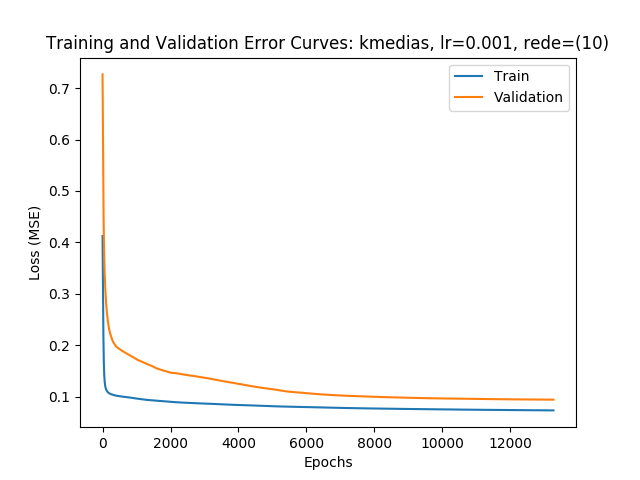

<IPython.core.display.Javascript object>


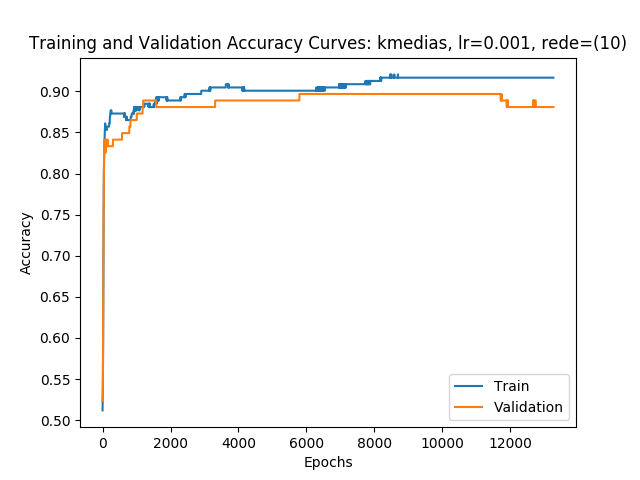

Matriz de confusão
[[1749  149]
 [   9   55]]

Train Loss:       0.0734
Validation Loss:  0.0943
Accuracy:         0.9195
MSE:              0.0805
AUROC:            0.9411


In [36]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [38]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.7684 - acc: 0.3611 - val_loss: 1.0645 - val_acc: 0.3730
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.7332 - acc: 0.3651 - val_loss: 1.0157 - val_acc: 0.3730
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.7010 - acc: 0.3690 - val_loss: 0.9717 - val_acc: 0.3889
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.6715 - acc: 0.3730 - val_loss: 0.9311 - val_acc: 0.3889
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.6443 - acc: 0.3810 - val_loss: 0.8935 - val_acc: 0.3889
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.6189 - acc: 0.3770 - val_loss: 0.8592 - val_acc: 0.3968
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.5959 - acc: 0.3770 - val_loss: 0.8271 - val_acc: 0.3968
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.1372 - acc: 0.8214 - val_loss: 0.2603 - val_acc: 0.7619
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.1359 - acc: 0.8214 - val_loss: 0.2582 - val_acc: 0.7698
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.1345 - acc: 0.8214 - val_loss: 0.2563 - val_acc: 0.7778
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.1333 - acc: 0.8214 - val_loss: 0.2544 - val_acc: 0.7857
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.1321 - acc: 0.8214 - val_loss: 0.2525 - val_acc: 0.7937
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.1312 - acc: 0.8214 - val_loss: 0.2508 - val_acc: 0.7937
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.1301 - acc: 0.8254 - val_loss: 0.2491 - val_acc: 0.8016
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.1291 - acc: 0.8254 - val_loss: 0.2471 - val_acc:

252/252 [==============================] - 0s - loss: 0.1101 - acc: 0.8730 - val_loss: 0.2034 - val_acc: 0.8413
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8690 - val_loss: 0.2031 - val_acc: 0.8413
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1099 - acc: 0.8690 - val_loss: 0.2027 - val_acc: 0.8413
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1098 - acc: 0.8690 - val_loss: 0.2024 - val_acc: 0.8413
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.2020 - val_acc: 0.8413
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8690 - val_loss: 0.2016 - val_acc: 0.8413
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8690 - val_loss: 0.2013 - val_acc: 0.8413
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1094 - acc: 0.8690 - val_loss: 0.2010 - v

252/252 [==============================] - 0s - loss: 0.1064 - acc: 0.8730 - val_loss: 0.1882 - val_acc: 0.8492
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1064 - acc: 0.8730 - val_loss: 0.1881 - val_acc: 0.8492
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1063 - acc: 0.8730 - val_loss: 0.1880 - val_acc: 0.8492
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1063 - acc: 0.8730 - val_loss: 0.1878 - val_acc: 0.8413
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1062 - acc: 0.8730 - val_loss: 0.1876 - val_acc: 0.8413
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1062 - acc: 0.8730 - val_loss: 0.1875 - val_acc: 0.8492
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1062 - acc: 0.8730 - val_loss: 0.1874 - val_acc: 0.8492
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1061 - acc: 0.8730 - val_loss: 0.1872 - v

252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8849 - val_loss: 0.1812 - val_acc: 0.8810
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8849 - val_loss: 0.1811 - val_acc: 0.8810
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8849 - val_loss: 0.1811 - val_acc: 0.8810
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8849 - val_loss: 0.1809 - val_acc: 0.8810
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8849 - val_loss: 0.1809 - val_acc: 0.8810
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8849 - val_loss: 0.1808 - val_acc: 0.8810
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8849 - val_loss: 0.1807 - val_acc: 0.8810
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8849 - val_loss: 0.1807 - v

252/252 [==============================] - 0s - loss: 0.1029 - acc: 0.8849 - val_loss: 0.1771 - val_acc: 0.8810
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1029 - acc: 0.8889 - val_loss: 0.1771 - val_acc: 0.8810
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1029 - acc: 0.8849 - val_loss: 0.1770 - val_acc: 0.8810
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1028 - acc: 0.8849 - val_loss: 0.1770 - val_acc: 0.8810
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1028 - acc: 0.8889 - val_loss: 0.1769 - val_acc: 0.8810
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1028 - acc: 0.8849 - val_loss: 0.1768 - val_acc: 0.8810
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1028 - acc: 0.8849 - val_loss: 0.1768 - val_acc: 0.8810
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8849 - val_loss: 0.1767 - v

252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8849 - val_loss: 0.1740 - val_acc: 0.8810
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8889 - val_loss: 0.1740 - val_acc: 0.8810
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8889 - val_loss: 0.1740 - val_acc: 0.8810
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8889 - val_loss: 0.1739 - val_acc: 0.8810
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8849 - val_loss: 0.1739 - val_acc: 0.8810
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8889 - val_loss: 0.1739 - val_acc: 0.8810
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1738 - val_acc: 0.8810
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8849 - val_loss: 0.1738 - v

252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8849 - val_loss: 0.1715 - val_acc: 0.8810
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8849 - val_loss: 0.1715 - val_acc: 0.8810
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8849 - val_loss: 0.1715 - val_acc: 0.8810
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8849 - val_loss: 0.1715 - val_acc: 0.8810
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8849 - val_loss: 0.1714 - val_acc: 0.8810
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8849 - val_loss: 0.1714 - val_acc: 0.8810
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8849 - val_loss: 0.1713 - val_acc: 0.8810
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8849 - val_loss: 0.1712 - v

252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8849 - val_loss: 0.1698 - val_acc: 0.8810
Epoch 505/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8849 - val_loss: 0.1698 - val_acc: 0.8810
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1697 - val_acc: 0.8810
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1697 - val_acc: 0.8810
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1696 - val_acc: 0.8810
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1696 - val_acc: 0.8810
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1696 - val_acc: 0.8810
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1696 - v

252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8849 - val_loss: 0.1682 - val_acc: 0.8810
Epoch 568/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8849 - val_loss: 0.1681 - val_acc: 0.8810
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8849 - val_loss: 0.1681 - val_acc: 0.8810
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8849 - val_loss: 0.1680 - val_acc: 0.8810
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8849 - val_loss: 0.1680 - val_acc: 0.8810
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8849 - val_loss: 0.1680 - val_acc: 0.8810
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8849 - val_loss: 0.1680 - val_acc: 0.8810
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8849 - val_loss: 0.1680 - v

252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8849 - val_loss: 0.1667 - val_acc: 0.8810
Epoch 631/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8849 - val_loss: 0.1667 - val_acc: 0.8810
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8849 - val_loss: 0.1667 - val_acc: 0.8810
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8849 - val_loss: 0.1666 - val_acc: 0.8810
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1666 - val_acc: 0.8810
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1666 - val_acc: 0.8810
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1666 - val_acc: 0.8810
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1666 - v

252/252 [==============================] - 0s - loss: 0.0964 - acc: 0.8849 - val_loss: 0.1657 - val_acc: 0.8810
Epoch 694/100000
252/252 [==============================] - 0s - loss: 0.0964 - acc: 0.8849 - val_loss: 0.1657 - val_acc: 0.8810
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.0964 - acc: 0.8849 - val_loss: 0.1656 - val_acc: 0.8810
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.0964 - acc: 0.8849 - val_loss: 0.1656 - val_acc: 0.8810
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8849 - val_loss: 0.1656 - val_acc: 0.8810
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8849 - val_loss: 0.1656 - val_acc: 0.8810
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8849 - val_loss: 0.1656 - val_acc: 0.8810
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8849 - val_loss: 0.1655 - v

252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8849 - val_loss: 0.1642 - val_acc: 0.8810
Epoch 757/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8849 - val_loss: 0.1642 - val_acc: 0.8810
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8889 - val_loss: 0.1642 - val_acc: 0.8810
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8889 - val_loss: 0.1641 - val_acc: 0.8810
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8849 - val_loss: 0.1641 - val_acc: 0.8810
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8849 - val_loss: 0.1641 - val_acc: 0.8810
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8889 - val_loss: 0.1641 - val_acc: 0.8810
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8849 - val_loss: 0.1641 - v

252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1632 - val_acc: 0.8810
Epoch 820/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1632 - val_acc: 0.8810
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1632 - val_acc: 0.8810
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1631 - val_acc: 0.8810
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1631 - val_acc: 0.8810
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1631 - val_acc: 0.8810
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1631 - val_acc: 0.8810
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8889 - val_loss: 0.1631 - v

252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1621 - val_acc: 0.8810
Epoch 883/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1621 - val_acc: 0.8810
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1622 - val_acc: 0.8810
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1622 - val_acc: 0.8810
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1621 - val_acc: 0.8810
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1622 - val_acc: 0.8810
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1621 - val_acc: 0.8810
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8889 - val_loss: 0.1621 - v

252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1615 - val_acc: 0.8810
Epoch 946/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1614 - val_acc: 0.8810
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1614 - val_acc: 0.8810
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8889 - val_loss: 0.1614 - val_acc: 0.8810
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8889 - val_loss: 0.1613 - val_acc: 0.8810
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8889 - val_loss: 0.1613 - val_acc: 0.8810
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8889 - val_loss: 0.1612 - val_acc: 0.8810
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.8889 - val_loss: 0.1613 - v

252/252 [==============================] - 0s - loss: 0.0928 - acc: 0.8889 - val_loss: 0.1603 - val_acc: 0.8810
Epoch 1009/100000
252/252 [==============================] - 0s - loss: 0.0928 - acc: 0.8889 - val_loss: 0.1603 - val_acc: 0.8810
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8889 - val_loss: 0.1603 - val_acc: 0.8810
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0928 - acc: 0.8889 - val_loss: 0.1602 - val_acc: 0.8810
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8889 - val_loss: 0.1602 - val_acc: 0.8810
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8889 - val_loss: 0.1602 - val_acc: 0.8810
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8889 - val_loss: 0.1602 - val_acc: 0.8810
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1072/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8889 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.0920 - acc: 0.8889 - val_loss: 0.1590 - val_acc: 0.8810
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.0920 - acc: 0.8889 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.0920 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 1135/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1579 - val_acc: 0.8810
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1579 - val_acc: 0.8810
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1579 - val_acc: 0.8810
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1579 - val_acc: 0.8810
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - ETA: 0s - loss: 0.0953 - acc: 0.875 - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1570 - val_acc: 0.8810
Epoch 1197/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1570 - val_acc: 0.8810
Epoch 1198/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1569 - val_acc: 0.8810
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1569 - val_acc: 0.8810
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1569 - val_acc: 0.8810
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1568 - val_acc: 0.8810
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1568 - val_acc: 0.8810
Epoch 1203/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1558 - val_acc: 0.8810
Epoch 1259/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1260/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1261/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1556 - val_acc: 0.8810
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 1321/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 1322/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1548 - val_acc: 0.8810
Epoch 1323/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1324/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8889 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8889 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 1384/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 1385/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1386/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1537 - val_acc: 0.8810
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1537 - val_acc: 0.8810
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8889 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1447/100000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8889 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1448/100000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8889 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1449/100000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8889 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1450/100000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8889 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8889 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8889 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.8810
Epoch 1510/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.8810
Epoch 1511/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.8810
Epoch 1512/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.8810
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.8810
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.8810
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.8810
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8889 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1572/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8889 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1573/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8889 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1574/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8889 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1575/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8889 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1576/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8889 - val_loss: 0.1511 - val_acc: 0.8810
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8889 - val_loss: 0.1511 - val_acc: 0.8810
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1504 - val_acc: 0.8810
Epoch 1635/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1504 - val_acc: 0.8810
Epoch 1636/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1504 - val_acc: 0.8810
Epoch 1637/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1504 - val_acc: 0.8810
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1504 - val_acc: 0.8810
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8889 - val_loss: 0.1504 - val_acc: 0.8810
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8889 - val_loss: 0.1503 - val_acc: 0.8810
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8889 - val_loss: 0.1497 - val_acc: 0.8810
Epoch 1697/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8889 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 1698/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8889 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 1699/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8889 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 1700/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8889 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 1701/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8889 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 1702/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8889 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1760/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1487 - val_acc: 0.8810
Epoch 1761/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.8889 - val_loss: 0.1487 - val_acc: 0.8810
Epoch 1762/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1763/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1487 - val_acc: 0.8810
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1487 - val_acc: 0.8810
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.8889 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1480 - val_acc: 0.8810
Epoch 1823/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1480 - val_acc: 0.8810
Epoch 1824/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1480 - val_acc: 0.8810
Epoch 1825/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1480 - val_acc: 0.8810
Epoch 1826/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1479 - val_acc: 0.8810
Epoch 1827/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1479 - val_acc: 0.8810
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1480 - val_acc: 0.8810
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.8889 - val_loss: 0.1471 - val_acc: 0.8810
Epoch 1886/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1471 - val_acc: 0.8810
Epoch 1887/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.8889 - val_loss: 0.1470 - val_acc: 0.8810
Epoch 1888/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8889 - val_loss: 0.1470 - val_acc: 0.8810
Epoch 1889/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8889 - val_loss: 0.1470 - val_acc: 0.8810
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1470 - val_acc: 0.8810
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8889 - val_loss: 0.1470 - val_acc: 0.8810
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 1948/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 1949/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1463 - val_acc: 0.8810
Epoch 1950/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1462 - val_acc: 0.8810
Epoch 1951/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1462 - val_acc: 0.8810
Epoch 1952/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1462 - val_acc: 0.8810
Epoch 1953/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1462 - val_acc: 0.8810
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1456 - val_acc: 0.8810
Epoch 2011/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1456 - val_acc: 0.8810
Epoch 2012/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1456 - val_acc: 0.8810
Epoch 2013/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1457 - val_acc: 0.8810
Epoch 2014/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1456 - val_acc: 0.8810
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1456 - val_acc: 0.8810
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1456 - val_acc: 0.8810
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1451 - val_acc: 0.8810
Epoch 2073/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1451 - val_acc: 0.8810
Epoch 2074/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1451 - val_acc: 0.8810
Epoch 2075/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1451 - val_acc: 0.8810
Epoch 2076/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1450 - val_acc: 0.8810
Epoch 2077/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1450 - val_acc: 0.8810
Epoch 2078/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1450 - val_acc: 0.8810
Epoch 2079/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1444 - val_acc: 0.8810
Epoch 2135/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1444 - val_acc: 0.8810
Epoch 2136/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1444 - val_acc: 0.8810
Epoch 2137/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1443 - val_acc: 0.8810
Epoch 2138/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1443 - val_acc: 0.8810
Epoch 2139/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1443 - val_acc: 0.8810
Epoch 2140/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1443 - val_acc: 0.8810
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2198/100000
252/252 [==============================] - ETA: 0s - loss: 0.0949 - acc: 0.937 - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2199/100000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.8929 - val_loss: 0.1437 - val_acc: 0.8810
Epoch 2200/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2201/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.1437 - val_acc: 0.8810
Epoch 2202/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2203/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.1438 - val_acc: 0.8810
Epoch 2204/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1432 - val_acc: 0.8810
Epoch 2260/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1432 - val_acc: 0.8810
Epoch 2261/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1432 - val_acc: 0.8810
Epoch 2262/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1432 - val_acc: 0.8810
Epoch 2263/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1432 - val_acc: 0.8810
Epoch 2264/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1432 - val_acc: 0.8810
Epoch 2265/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1432 - val_acc: 0.8810
Epoch 2266/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1427 - val_acc: 0.8810
Epoch 2323/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1427 - val_acc: 0.8810
Epoch 2324/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1427 - val_acc: 0.8810
Epoch 2325/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1427 - val_acc: 0.8810
Epoch 2326/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1426 - val_acc: 0.8810
Epoch 2327/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1426 - val_acc: 0.8810
Epoch 2328/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1426 - val_acc: 0.8810
Epoch 2329/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1422 - val_acc: 0.8810
Epoch 2386/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1422 - val_acc: 0.8810
Epoch 2387/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1421 - val_acc: 0.8810
Epoch 2388/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1421 - val_acc: 0.8810
Epoch 2389/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1421 - val_acc: 0.8810
Epoch 2390/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1421 - val_acc: 0.8810
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1421 - val_acc: 0.8810
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8929 - val_loss: 0.1415 - val_acc: 0.8810
Epoch 2449/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1415 - val_acc: 0.8810
Epoch 2450/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1415 - val_acc: 0.8810
Epoch 2451/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1416 - val_acc: 0.8810
Epoch 2452/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8929 - val_loss: 0.1416 - val_acc: 0.8810
Epoch 2453/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1415 - val_acc: 0.8810
Epoch 2454/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1416 - val_acc: 0.8810
Epoch 2455/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.8929 - val_loss: 0.1410 - val_acc: 0.8810
Epoch 2512/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8929 - val_loss: 0.1409 - val_acc: 0.8810
Epoch 2513/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8929 - val_loss: 0.1409 - val_acc: 0.8810
Epoch 2514/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8929 - val_loss: 0.1410 - val_acc: 0.8810
Epoch 2515/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8929 - val_loss: 0.1409 - val_acc: 0.8810
Epoch 2516/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8929 - val_loss: 0.1409 - val_acc: 0.8810
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8929 - val_loss: 0.1409 - val_acc: 0.8810
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.8929 - val_loss: 0.1

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1472/1962 [=====================>........] - ETA: 0s[0.07418731588843705, 0.9194699286442406]


<IPython.core.display.Javascript object>


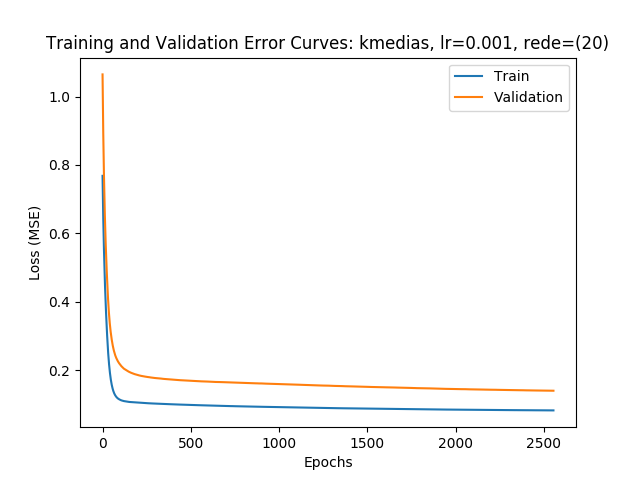

<IPython.core.display.Javascript object>


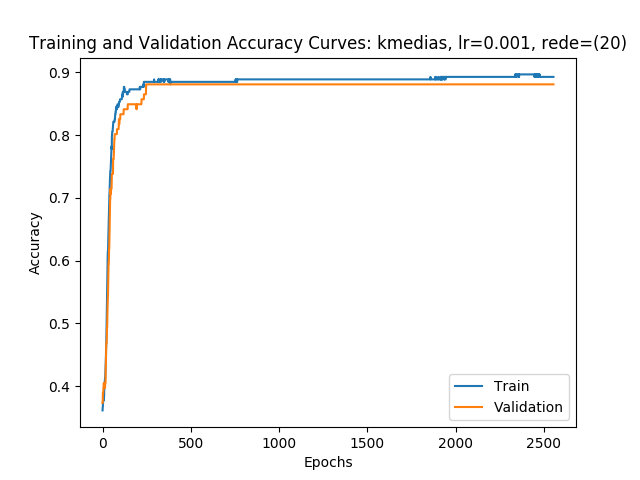

Matriz de confusão
[[1748  150]
 [   7   57]]

Train Loss:       0.0835
Validation Loss:  0.1408
Accuracy:         0.9200
MSE:              0.0800
AUROC:            0.9573


In [40]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [42]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4935 - acc: 0.4960 - val_loss: 0.5170 - val_acc: 0.4841
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4931 - acc: 0.4960 - val_loss: 0.5168 - val_acc: 0.4841
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.4927 - acc: 0.4960 - val_loss: 0.5167 - val_acc: 0.4762
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.4922 - acc: 0.4960 - val_loss: 0.5165 - val_acc: 0.4762
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.4918 - acc: 0.4960 - val_loss: 0.5163 - val_acc: 0.4762
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.4914 - acc: 0.4960 - val_loss: 0.5161 - val_acc: 0.4762
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.4909 - acc: 0.4960 - val_loss: 0.5158 - val_acc: 0.4762
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.2105 - acc: 0.6746 - val_loss: 0.2955 - val_acc: 0.6270
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.2076 - acc: 0.6944 - val_loss: 0.2929 - val_acc: 0.6270
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.2049 - acc: 0.7063 - val_loss: 0.2905 - val_acc: 0.6349
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.2024 - acc: 0.7183 - val_loss: 0.2883 - val_acc: 0.6349
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.2000 - acc: 0.7183 - val_loss: 0.2861 - val_acc: 0.6349
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.1975 - acc: 0.7302 - val_loss: 0.2840 - val_acc: 0.6508
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.1950 - acc: 0.7421 - val_loss: 0.2819 - val_acc: 0.6587
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.1925 - acc: 0.7500 - val_loss: 0.2800 - val_acc:

252/252 [==============================] - 0s - loss: 0.1415 - acc: 0.8611 - val_loss: 0.2240 - val_acc: 0.8175
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1412 - acc: 0.8611 - val_loss: 0.2234 - val_acc: 0.8175
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1409 - acc: 0.8611 - val_loss: 0.2229 - val_acc: 0.8175
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1406 - acc: 0.8651 - val_loss: 0.2224 - val_acc: 0.8095
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1403 - acc: 0.8651 - val_loss: 0.2218 - val_acc: 0.8095
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1400 - acc: 0.8651 - val_loss: 0.2213 - val_acc: 0.8095
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1398 - acc: 0.8651 - val_loss: 0.2208 - val_acc: 0.8095
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1395 - acc: 0.8651 - val_loss: 0.2203 - v

252/252 [==============================] - 0s - loss: 0.1306 - acc: 0.8730 - val_loss: 0.2004 - val_acc: 0.8254
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1305 - acc: 0.8730 - val_loss: 0.2002 - val_acc: 0.8254
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1304 - acc: 0.8730 - val_loss: 0.1999 - val_acc: 0.8254
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1304 - acc: 0.8770 - val_loss: 0.1997 - val_acc: 0.8254
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1303 - acc: 0.8730 - val_loss: 0.1995 - val_acc: 0.8333
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1302 - acc: 0.8730 - val_loss: 0.1992 - val_acc: 0.8333
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1301 - acc: 0.8730 - val_loss: 0.1990 - val_acc: 0.8333
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1300 - acc: 0.8730 - val_loss: 0.1988 - v

252/252 [==============================] - 0s - loss: 0.1258 - acc: 0.8690 - val_loss: 0.1893 - val_acc: 0.8492
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1257 - acc: 0.8690 - val_loss: 0.1892 - val_acc: 0.8492
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1256 - acc: 0.8690 - val_loss: 0.1890 - val_acc: 0.8492
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1256 - acc: 0.8690 - val_loss: 0.1889 - val_acc: 0.8492
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1255 - acc: 0.8690 - val_loss: 0.1888 - val_acc: 0.8492
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1255 - acc: 0.8690 - val_loss: 0.1887 - val_acc: 0.8492
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1254 - acc: 0.8690 - val_loss: 0.1885 - val_acc: 0.8492
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1253 - acc: 0.8690 - val_loss: 0.1884 - v

252/252 [==============================] - 0s - loss: 0.1223 - acc: 0.8690 - val_loss: 0.1832 - val_acc: 0.8492
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1223 - acc: 0.8690 - val_loss: 0.1831 - val_acc: 0.8492
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1222 - acc: 0.8690 - val_loss: 0.1830 - val_acc: 0.8492
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1222 - acc: 0.8690 - val_loss: 0.1829 - val_acc: 0.8492
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1221 - acc: 0.8690 - val_loss: 0.1828 - val_acc: 0.8492
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1221 - acc: 0.8690 - val_loss: 0.1827 - val_acc: 0.8492
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1220 - acc: 0.8690 - val_loss: 0.1826 - val_acc: 0.8492
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1220 - acc: 0.8690 - val_loss: 0.1825 - v

252/252 [==============================] - 0s - loss: 0.1194 - acc: 0.8690 - val_loss: 0.1789 - val_acc: 0.8492
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1194 - acc: 0.8690 - val_loss: 0.1789 - val_acc: 0.8492
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1193 - acc: 0.8690 - val_loss: 0.1788 - val_acc: 0.8492
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1193 - acc: 0.8690 - val_loss: 0.1787 - val_acc: 0.8492
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1193 - acc: 0.8690 - val_loss: 0.1787 - val_acc: 0.8492
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8690 - val_loss: 0.1787 - val_acc: 0.8492
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8690 - val_loss: 0.1786 - val_acc: 0.8492
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8690 - val_loss: 0.1786 - v

252/252 [==============================] - 0s - loss: 0.1171 - acc: 0.8690 - val_loss: 0.1761 - val_acc: 0.8571
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.1170 - acc: 0.8730 - val_loss: 0.1761 - val_acc: 0.8571
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.1170 - acc: 0.8730 - val_loss: 0.1761 - val_acc: 0.8571
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.1170 - acc: 0.8730 - val_loss: 0.1760 - val_acc: 0.8571
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8730 - val_loss: 0.1760 - val_acc: 0.8571
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8690 - val_loss: 0.1759 - val_acc: 0.8571
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8690 - val_loss: 0.1759 - val_acc: 0.8571
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.1168 - acc: 0.8730 - val_loss: 0.1759 - v

252/252 [==============================] - 0s - loss: 0.1149 - acc: 0.8770 - val_loss: 0.1742 - val_acc: 0.8492
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.1149 - acc: 0.8770 - val_loss: 0.1742 - val_acc: 0.8492
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.1149 - acc: 0.8770 - val_loss: 0.1741 - val_acc: 0.8492
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.1148 - acc: 0.8770 - val_loss: 0.1741 - val_acc: 0.8492
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.1148 - acc: 0.8770 - val_loss: 0.1741 - val_acc: 0.8492
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.1148 - acc: 0.8730 - val_loss: 0.1741 - val_acc: 0.8492
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.1147 - acc: 0.8770 - val_loss: 0.1740 - val_acc: 0.8492
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.1147 - acc: 0.8770 - val_loss: 0.1740 - v

252/252 [==============================] - 0s - loss: 0.1126 - acc: 0.8730 - val_loss: 0.1724 - val_acc: 0.8571
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.1126 - acc: 0.8730 - val_loss: 0.1724 - val_acc: 0.8571
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8730 - val_loss: 0.1723 - val_acc: 0.8571
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8730 - val_loss: 0.1723 - val_acc: 0.8571
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8730 - val_loss: 0.1722 - val_acc: 0.8571
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8730 - val_loss: 0.1722 - val_acc: 0.8571
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8730 - val_loss: 0.1722 - val_acc: 0.8571
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8730 - val_loss: 0.1722 - v

252/252 [==============================] - 0s - loss: 0.1105 - acc: 0.8690 - val_loss: 0.1706 - val_acc: 0.8571
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.1104 - acc: 0.8690 - val_loss: 0.1706 - val_acc: 0.8571
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.1104 - acc: 0.8690 - val_loss: 0.1705 - val_acc: 0.8571
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.1104 - acc: 0.8690 - val_loss: 0.1705 - val_acc: 0.8571
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8690 - val_loss: 0.1705 - val_acc: 0.8571
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8690 - val_loss: 0.1705 - val_acc: 0.8571
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8690 - val_loss: 0.1704 - val_acc: 0.8571
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8690 - val_loss: 0.1704 - v

252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8651 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8651 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8651 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8651 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.1084 - acc: 0.8651 - val_loss: 0.1685 - val_acc: 0.8730
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.1084 - acc: 0.8651 - val_loss: 0.1685 - val_acc: 0.8730
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.1084 - acc: 0.8651 - val_loss: 0.1684 - val_acc: 0.8730
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.1083 - acc: 0.8651 - val_loss: 0.1684 - v

252/252 [==============================] - 0s - loss: 0.1070 - acc: 0.8611 - val_loss: 0.1673 - val_acc: 0.8651
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8611 - val_loss: 0.1673 - val_acc: 0.8651
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8611 - val_loss: 0.1672 - val_acc: 0.8651
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8611 - val_loss: 0.1672 - val_acc: 0.8651
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8611 - val_loss: 0.1672 - val_acc: 0.8651
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8611 - val_loss: 0.1672 - val_acc: 0.8651
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8611 - val_loss: 0.1672 - val_acc: 0.8651
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8611 - val_loss: 0.1671 - v

252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8690 - val_loss: 0.1666 - val_acc: 0.8651
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8690 - val_loss: 0.1666 - val_acc: 0.8651
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8690 - val_loss: 0.1666 - val_acc: 0.8651
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8651 - val_loss: 0.1666 - val_acc: 0.8651
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8690 - val_loss: 0.1666 - val_acc: 0.8651
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8690 - val_loss: 0.1666 - val_acc: 0.8651
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8690 - val_loss: 0.1666 - val_acc: 0.8651
Epoch 827/100000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8690 - val_loss: 0.1666 - v

252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1656 - val_acc: 0.8651
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1656 - val_acc: 0.8651
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1656 - val_acc: 0.8651
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1655 - val_acc: 0.8651
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1655 - val_acc: 0.8651
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1655 - val_acc: 0.8651
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1655 - val_acc: 0.8651
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1655 - v

252/252 [==============================] - 0s - loss: 0.1035 - acc: 0.8730 - val_loss: 0.1646 - val_acc: 0.8651
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.1035 - acc: 0.8730 - val_loss: 0.1646 - val_acc: 0.8651
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.1035 - acc: 0.8730 - val_loss: 0.1646 - val_acc: 0.8651
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8730 - val_loss: 0.1646 - val_acc: 0.8651
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8730 - val_loss: 0.1646 - val_acc: 0.8651
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8730 - val_loss: 0.1646 - val_acc: 0.8651
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8730 - val_loss: 0.1645 - val_acc: 0.8651
Epoch 953/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8730 - val_loss: 0.1645 - v

252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8730 - val_loss: 0.1638 - val_acc: 0.8651
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8730 - val_loss: 0.1638 - val_acc: 0.8651
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8730 - val_loss: 0.1637 - val_acc: 0.8651
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.1025 - acc: 0.8730 - val_loss: 0.1637 - val_acc: 0.8651
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.1025 - acc: 0.8730 - val_loss: 0.1637 - val_acc: 0.8651
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.1025 - acc: 0.8730 - val_loss: 0.1637 - val_acc: 0.8651
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.1025 - acc: 0.8730 - val_loss: 0.1637 - val_acc: 0.8651
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.1025 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1631 - val_acc: 0.8651
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1631 - val_acc: 0.8651
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1631 - val_acc: 0.8651
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1630 - val_acc: 0.8651
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1630 - val_acc: 0.8651
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.1017 - acc: 0.8730 - val_loss: 0.1630 - val_acc: 0.8651
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.1017 - acc: 0.8730 - val_loss: 0.1631 - val_acc: 0.8651
Epoch 1079/100000
252/252 [==============================] - 0s - loss: 0.1017 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8770 - val_loss: 0.1623 - val_acc: 0.8651
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8770 - val_loss: 0.1623 - val_acc: 0.8651
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8770 - val_loss: 0.1623 - val_acc: 0.8651
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8770 - val_loss: 0.1623 - val_acc: 0.8651
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8770 - val_loss: 0.1623 - val_acc: 0.8651
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8770 - val_loss: 0.1623 - val_acc: 0.8651
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1623 - val_acc: 0.8651
Epoch 1142/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8810 - val_loss: 0.1613 - val_acc: 0.8730
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8810 - val_loss: 0.1613 - val_acc: 0.8730
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8810 - val_loss: 0.1613 - val_acc: 0.8730
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8810 - val_loss: 0.1612 - val_acc: 0.8730
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8810 - val_loss: 0.1612 - val_acc: 0.8730
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8810 - val_loss: 0.1612 - val_acc: 0.8730
Epoch 1204/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8810 - val_loss: 0.1612 - val_acc: 0.8730
Epoch 1205/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1604 - val_acc: 0.8730
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1604 - val_acc: 0.8730
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1604 - val_acc: 0.8730
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1603 - val_acc: 0.8730
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1603 - val_acc: 0.8730
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1603 - val_acc: 0.8730
Epoch 1267/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1603 - val_acc: 0.8730
Epoch 1268/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1594 - val_acc: 0.8730
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1594 - val_acc: 0.8730
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1594 - val_acc: 0.8730
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1594 - val_acc: 0.8730
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1593 - val_acc: 0.8730
Epoch 1329/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1593 - val_acc: 0.8730
Epoch 1330/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1593 - val_acc: 0.8730
Epoch 1331/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0983 - acc: 0.8810 - val_loss: 0.1581 - val_acc: 0.8730
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8730
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8730
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8730
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8730
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1579 - val_acc: 0.8730
Epoch 1393/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1579 - val_acc: 0.8730
Epoch 1394/100000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8810 - val_loss: 0.1569 - val_acc: 0.8730
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8810 - val_loss: 0.1569 - val_acc: 0.8730
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8730
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8730
Epoch 1454/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8730
Epoch 1455/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8730
Epoch 1456/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8730
Epoch 1457/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1558 - val_acc: 0.8730
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1519/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1520/100000
252/252 [==============================] - 0s - loss: 0.0971 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1546 - val_acc: 0.8730
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1546 - val_acc: 0.8730
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1546 - val_acc: 0.8730
Epoch 1579/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1546 - val_acc: 0.8730
Epoch 1580/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1546 - val_acc: 0.8730
Epoch 1581/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1546 - val_acc: 0.8730
Epoch 1582/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1545 - val_acc: 0.8730
Epoch 1583/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8730
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8730
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8730
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8730
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8730
Epoch 1644/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8810 - val_loss: 0.1536 - val_acc: 0.8730
Epoch 1645/100000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8849 - val_loss: 0.1535 - val_acc: 0.8730
Epoch 1646/100000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1527 - val_acc: 0.8730
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1527 - val_acc: 0.8730
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1527 - val_acc: 0.8730
Epoch 1705/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1527 - val_acc: 0.8730
Epoch 1706/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1527 - val_acc: 0.8730
Epoch 1707/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1527 - val_acc: 0.8730
Epoch 1708/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1527 - val_acc: 0.8730
Epoch 1709/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8889 - val_loss: 0.1517 - val_acc: 0.8730
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8889 - val_loss: 0.1517 - val_acc: 0.8730
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8889 - val_loss: 0.1517 - val_acc: 0.8730
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8889 - val_loss: 0.1517 - val_acc: 0.8730
Epoch 1769/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8889 - val_loss: 0.1517 - val_acc: 0.8730
Epoch 1770/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8849 - val_loss: 0.1517 - val_acc: 0.8730
Epoch 1771/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8889 - val_loss: 0.1516 - val_acc: 0.8730
Epoch 1772/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1508 - val_acc: 0.8730
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1508 - val_acc: 0.8730
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1507 - val_acc: 0.8730
Epoch 1831/100000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1507 - val_acc: 0.8730
Epoch 1832/100000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1507 - val_acc: 0.8730
Epoch 1833/100000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1507 - val_acc: 0.8730
Epoch 1834/100000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1507 - val_acc: 0.8730
Epoch 1835/100000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1499 - val_acc: 0.8730
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1499 - val_acc: 0.8730
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1499 - val_acc: 0.8730
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1499 - val_acc: 0.8730
Epoch 1894/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1498 - val_acc: 0.8730
Epoch 1895/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1498 - val_acc: 0.8730
Epoch 1896/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1499 - val_acc: 0.8730
Epoch 1897/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1490 - val_acc: 0.8651
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1490 - val_acc: 0.8651
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1490 - val_acc: 0.8651
Epoch 1956/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1490 - val_acc: 0.8651
Epoch 1957/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1489 - val_acc: 0.8651
Epoch 1958/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1489 - val_acc: 0.8651
Epoch 1959/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1489 - val_acc: 0.8651
Epoch 1960/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1482 - val_acc: 0.8651
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8889 - val_loss: 0.1482 - val_acc: 0.8651
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1482 - val_acc: 0.8651
Epoch 2019/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1482 - val_acc: 0.8651
Epoch 2020/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1482 - val_acc: 0.8651
Epoch 2021/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1481 - val_acc: 0.8651
Epoch 2022/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1481 - val_acc: 0.8651
Epoch 2023/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1472 - val_acc: 0.8651
Epoch 2080/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1471 - val_acc: 0.8651
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1471 - val_acc: 0.8651
Epoch 2082/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1471 - val_acc: 0.8651
Epoch 2083/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1471 - val_acc: 0.8651
Epoch 2084/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1470 - val_acc: 0.8651
Epoch 2085/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1470 - val_acc: 0.8651
Epoch 2086/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1461 - val_acc: 0.8651
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1461 - val_acc: 0.8651
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1461 - val_acc: 0.8651
Epoch 2145/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1461 - val_acc: 0.8651
Epoch 2146/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1461 - val_acc: 0.8651
Epoch 2147/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1460 - val_acc: 0.8651
Epoch 2148/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1460 - val_acc: 0.8651
Epoch 2149/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8651
Epoch 2206/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8651
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8651
Epoch 2208/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8651
Epoch 2209/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8651
Epoch 2210/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8651
Epoch 2211/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1452 - val_acc: 0.8651
Epoch 2212/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8889 - val_loss: 0.1442 - val_acc: 0.8651
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8889 - val_loss: 0.1442 - val_acc: 0.8651
Epoch 2270/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8889 - val_loss: 0.1442 - val_acc: 0.8651
Epoch 2271/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8889 - val_loss: 0.1442 - val_acc: 0.8651
Epoch 2272/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8889 - val_loss: 0.1442 - val_acc: 0.8651
Epoch 2273/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8849 - val_loss: 0.1441 - val_acc: 0.8651
Epoch 2274/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8889 - val_loss: 0.1441 - val_acc: 0.8651
Epoch 2275/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8810 - val_loss: 0.1434 - val_acc: 0.8651
Epoch 2331/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8849 - val_loss: 0.1434 - val_acc: 0.8651
Epoch 2332/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8849 - val_loss: 0.1433 - val_acc: 0.8651
Epoch 2333/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8849 - val_loss: 0.1433 - val_acc: 0.8651
Epoch 2334/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8849 - val_loss: 0.1433 - val_acc: 0.8651
Epoch 2335/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8849 - val_loss: 0.1433 - val_acc: 0.8651
Epoch 2336/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8849 - val_loss: 0.1433 - val_acc: 0.8651
Epoch 2337/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8849 - val_loss: 0.1425 - val_acc: 0.8651
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8810 - val_loss: 0.1425 - val_acc: 0.8651
Epoch 2395/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8810 - val_loss: 0.1424 - val_acc: 0.8651
Epoch 2396/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8810 - val_loss: 0.1424 - val_acc: 0.8651
Epoch 2397/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8849 - val_loss: 0.1424 - val_acc: 0.8651
Epoch 2398/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8810 - val_loss: 0.1424 - val_acc: 0.8651
Epoch 2399/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8810 - val_loss: 0.1424 - val_acc: 0.8651
Epoch 2400/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8810 - val_loss: 0.1417 - val_acc: 0.8651
Epoch 2457/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8810 - val_loss: 0.1417 - val_acc: 0.8651
Epoch 2458/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8810 - val_loss: 0.1416 - val_acc: 0.8651
Epoch 2459/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8810 - val_loss: 0.1416 - val_acc: 0.8651
Epoch 2460/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8810 - val_loss: 0.1416 - val_acc: 0.8651
Epoch 2461/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8810 - val_loss: 0.1416 - val_acc: 0.8651
Epoch 2462/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8810 - val_loss: 0.1416 - val_acc: 0.8651
Epoch 2463/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1408 - val_acc: 0.8651
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1408 - val_acc: 0.8651
Epoch 2521/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1407 - val_acc: 0.8651
Epoch 2522/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1407 - val_acc: 0.8651
Epoch 2523/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1407 - val_acc: 0.8651
Epoch 2524/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1407 - val_acc: 0.8651
Epoch 2525/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1406 - val_acc: 0.8651
Epoch 2526/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8810 - val_loss: 0.1393 - val_acc: 0.8651
Epoch 2583/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8810 - val_loss: 0.1392 - val_acc: 0.8651
Epoch 2584/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8810 - val_loss: 0.1392 - val_acc: 0.8651
Epoch 2585/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8810 - val_loss: 0.1392 - val_acc: 0.8651
Epoch 2586/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8810 - val_loss: 0.1392 - val_acc: 0.8651
Epoch 2587/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8810 - val_loss: 0.1391 - val_acc: 0.8651
Epoch 2588/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8810 - val_loss: 0.1391 - val_acc: 0.8651
Epoch 2589/100000
252/252 [==============================] - ETA: 0s - loss: 0.0598 - acc: 0.968 - 0s - loss

252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1376 - val_acc: 0.8651
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1376 - val_acc: 0.8651
Epoch 2646/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1376 - val_acc: 0.8651
Epoch 2647/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1375 - val_acc: 0.8651
Epoch 2648/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1375 - val_acc: 0.8651
Epoch 2649/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1375 - val_acc: 0.8651
Epoch 2650/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1374 - val_acc: 0.8651
Epoch 2651/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1359 - val_acc: 0.8651
Epoch 2708/100000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1358 - val_acc: 0.8651
Epoch 2709/100000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1358 - val_acc: 0.8651
Epoch 2710/100000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1358 - val_acc: 0.8651
Epoch 2711/100000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1358 - val_acc: 0.8651
Epoch 2712/100000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1358 - val_acc: 0.8651
Epoch 2713/100000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1357 - val_acc: 0.8651
Epoch 2714/100000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1343 - val_acc: 0.8651
Epoch 2771/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1343 - val_acc: 0.8651
Epoch 2772/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1342 - val_acc: 0.8651
Epoch 2773/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1342 - val_acc: 0.8651
Epoch 2774/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1342 - val_acc: 0.8651
Epoch 2775/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1342 - val_acc: 0.8651
Epoch 2776/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1341 - val_acc: 0.8651
Epoch 2777/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1329 - val_acc: 0.8651
Epoch 2834/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1329 - val_acc: 0.8651
Epoch 2835/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1328 - val_acc: 0.8651
Epoch 2836/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1328 - val_acc: 0.8651
Epoch 2837/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1328 - val_acc: 0.8651
Epoch 2838/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1328 - val_acc: 0.8651
Epoch 2839/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1327 - val_acc: 0.8651
Epoch 2840/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1315 - val_acc: 0.8651
Epoch 2897/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1315 - val_acc: 0.8651
Epoch 2898/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1315 - val_acc: 0.8651
Epoch 2899/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1314 - val_acc: 0.8651
Epoch 2900/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1314 - val_acc: 0.8651
Epoch 2901/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1314 - val_acc: 0.8651
Epoch 2902/100000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1314 - val_acc: 0.8651
Epoch 2903/100000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 2960/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 2961/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 2962/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 2963/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1301 - val_acc: 0.8651
Epoch 2964/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1301 - val_acc: 0.8651
Epoch 2965/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1301 - val_acc: 0.8651
Epoch 2966/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1289 - val_acc: 0.8651
Epoch 3023/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1289 - val_acc: 0.8651
Epoch 3024/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1289 - val_acc: 0.8651
Epoch 3025/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1289 - val_acc: 0.8651
Epoch 3026/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1289 - val_acc: 0.8651
Epoch 3027/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 3028/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 3029/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8849 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 3086/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8810 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 3087/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8849 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 3088/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8810 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 3089/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8849 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 3090/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8849 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 3091/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8849 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 3092/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1267 - val_acc: 0.8651
Epoch 3149/100000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 3150/100000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 3151/100000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 3152/100000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 3153/100000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 3154/100000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 3155/100000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1259 - val_acc: 0.8651
Epoch 3212/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1259 - val_acc: 0.8651
Epoch 3213/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1259 - val_acc: 0.8651
Epoch 3214/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1260 - val_acc: 0.8651
Epoch 3215/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1259 - val_acc: 0.8651
Epoch 3216/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1259 - val_acc: 0.8651
Epoch 3217/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1259 - val_acc: 0.8651
Epoch 3218/100000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.8810 - val_loss: 0.1

In [43]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1152/1962 [================>.............] - ETA: 0s[0.054862692173680519, 0.92354740061162077]


<IPython.core.display.Javascript object>


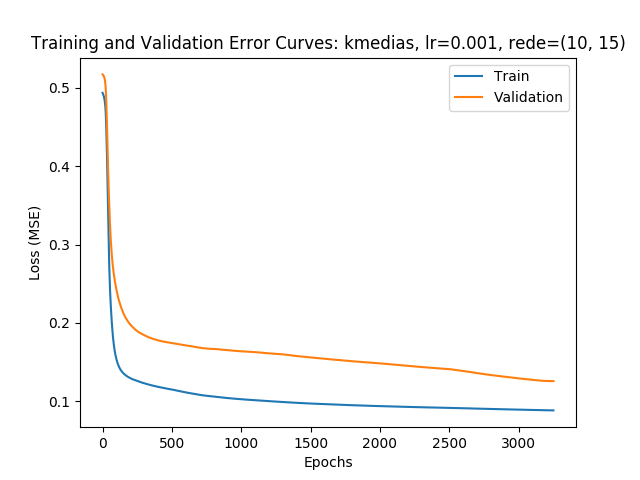

<IPython.core.display.Javascript object>


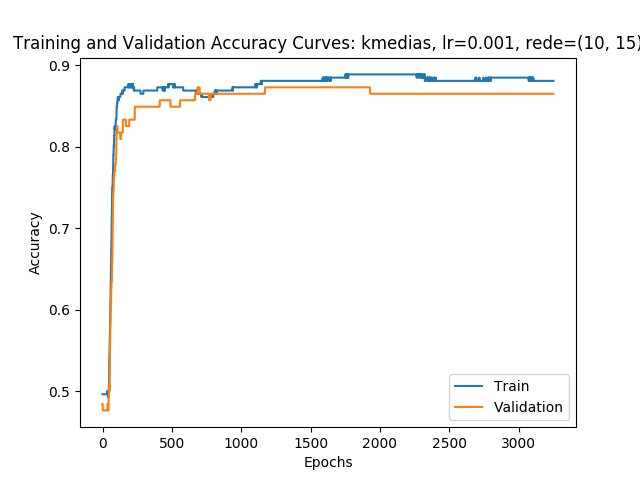

Matriz de confusão
[[1756  142]
 [   8   56]]

Train Loss:       0.0885
Validation Loss:  0.1258
Accuracy:         0.9235
MSE:              0.0765
AUROC:            0.9390


In [44]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history, graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [46]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4182 - acc: 0.4286 - val_loss: 0.4333 - val_acc: 0.4365
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4067 - acc: 0.4325 - val_loss: 0.4220 - val_acc: 0.4444
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3955 - acc: 0.4405 - val_loss: 0.4112 - val_acc: 0.4524
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3848 - acc: 0.4444 - val_loss: 0.4007 - val_acc: 0.4524
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.3745 - acc: 0.4484 - val_loss: 0.3906 - val_acc: 0.4603
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.3646 - acc: 0.4524 - val_loss: 0.3812 - val_acc: 0.4603
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.3551 - acc: 0.4563 - val_loss: 0.3724 - val_acc: 0.4683
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.1528 - acc: 0.8294 - val_loss: 0.1992 - val_acc: 0.7857
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.1518 - acc: 0.8254 - val_loss: 0.1984 - val_acc: 0.7857
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.1509 - acc: 0.8294 - val_loss: 0.1977 - val_acc: 0.7857
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.1500 - acc: 0.8294 - val_loss: 0.1969 - val_acc: 0.7857
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.1491 - acc: 0.8294 - val_loss: 0.1963 - val_acc: 0.7857
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.1483 - acc: 0.8294 - val_loss: 0.1956 - val_acc: 0.7857
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.1474 - acc: 0.8294 - val_loss: 0.1949 - val_acc: 0.7857
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.1466 - acc: 0.8294 - val_loss: 0.1943 - val_acc:

252/252 [==============================] - 0s - loss: 0.1215 - acc: 0.8532 - val_loss: 0.1734 - val_acc: 0.8175
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1213 - acc: 0.8532 - val_loss: 0.1733 - val_acc: 0.8175
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1210 - acc: 0.8532 - val_loss: 0.1731 - val_acc: 0.8175
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1208 - acc: 0.8571 - val_loss: 0.1729 - val_acc: 0.8175
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1205 - acc: 0.8571 - val_loss: 0.1726 - val_acc: 0.8175
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1203 - acc: 0.8571 - val_loss: 0.1723 - val_acc: 0.8175
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1201 - acc: 0.8571 - val_loss: 0.1721 - val_acc: 0.8175
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1199 - acc: 0.8571 - val_loss: 0.1718 - v

252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8730 - val_loss: 0.1639 - val_acc: 0.8413
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8690 - val_loss: 0.1638 - val_acc: 0.8413
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8770 - val_loss: 0.1637 - val_acc: 0.8413
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1109 - acc: 0.8730 - val_loss: 0.1636 - val_acc: 0.8413
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1108 - acc: 0.8730 - val_loss: 0.1634 - val_acc: 0.8413
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1107 - acc: 0.8690 - val_loss: 0.1632 - val_acc: 0.8413
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1105 - acc: 0.8690 - val_loss: 0.1631 - val_acc: 0.8413
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1104 - acc: 0.8690 - val_loss: 0.1629 - v

252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8690 - val_loss: 0.1571 - val_acc: 0.8413
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8690 - val_loss: 0.1571 - val_acc: 0.8413
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8690 - val_loss: 0.1570 - val_acc: 0.8413
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8690 - val_loss: 0.1569 - val_acc: 0.8413
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1569 - val_acc: 0.8413
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8690 - val_loss: 0.1568 - val_acc: 0.8413
Epoch 259/100000
252/252 [==============================] - ETA: 0s - loss: 0.1156 - acc: 0.812 - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1567 - val_acc: 0.8413
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.104

252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8810 - val_loss: 0.1533 - val_acc: 0.8492
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8810 - val_loss: 0.1532 - val_acc: 0.8492
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8810 - val_loss: 0.1532 - val_acc: 0.8492
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8810 - val_loss: 0.1531 - val_acc: 0.8492
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8810 - val_loss: 0.1531 - val_acc: 0.8492
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8810 - val_loss: 0.1530 - val_acc: 0.8492
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8810 - val_loss: 0.1529 - val_acc: 0.8492
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8810 - val_loss: 0.1528 - v

252/252 [==============================] - 0s - loss: 0.0979 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8571
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.0979 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8571
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8571
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8849 - val_loss: 0.1498 - val_acc: 0.8571
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8849 - val_loss: 0.1497 - val_acc: 0.8571
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8810 - val_loss: 0.1497 - val_acc: 0.8571
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8810 - val_loss: 0.1496 - val_acc: 0.8571
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8849 - val_loss: 0.1496 - v

252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8889 - val_loss: 0.1466 - val_acc: 0.8492
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8889 - val_loss: 0.1466 - val_acc: 0.8492
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8889 - val_loss: 0.1466 - val_acc: 0.8492
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8889 - val_loss: 0.1465 - val_acc: 0.8492
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8889 - val_loss: 0.1465 - val_acc: 0.8492
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8889 - val_loss: 0.1464 - val_acc: 0.8492
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8889 - val_loss: 0.1464 - val_acc: 0.8492
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8889 - val_loss: 0.1463 - v

252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8571
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8571
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8571
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8571
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8571
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1429 - val_acc: 0.8571
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1428 - val_acc: 0.8571
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1428 - v

252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8929 - val_loss: 0.1404 - val_acc: 0.8571
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8929 - val_loss: 0.1404 - val_acc: 0.8571
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8929 - val_loss: 0.1404 - val_acc: 0.8571
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8929 - val_loss: 0.1404 - val_acc: 0.8571
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1403 - val_acc: 0.8571
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1403 - val_acc: 0.8571
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1403 - val_acc: 0.8571
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1402 - v

252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1381 - val_acc: 0.8571
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1381 - val_acc: 0.8571
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8571
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8571
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8571
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8571
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8968 - val_loss: 0.1379 - val_acc: 0.8571
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8968 - val_loss: 0.1379 - v

252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1362 - val_acc: 0.8571
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1362 - val_acc: 0.8571
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.9008 - val_loss: 0.1361 - v

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.9008 - val_loss: 0.1348 - val_acc: 0.8571
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.9008 - val_loss: 0.1347 - val_acc: 0.8571
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1347 - val_acc: 0.8571
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9008 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.9048 - val_loss: 0.1345 - v

252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.9048 - val_loss: 0.1331 - val_acc: 0.8571
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.9008 - val_loss: 0.1331 - val_acc: 0.8571
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.9008 - val_loss: 0.1331 - val_acc: 0.8571
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.9008 - val_loss: 0.1331 - val_acc: 0.8571
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.9008 - val_loss: 0.1331 - val_acc: 0.8571
Epoch 825/100000
252/252 [==============================] - ETA: 0s - loss: 0.0632 - acc: 0.937 - 0s - loss: 0.0885 - acc: 0.9008 - val_loss: 0.1330 - val_acc: 0.8571
Epoch 826/100000
252/252 [==============================] - ETA: 0s - loss: 0.0981 - acc: 0.843 - 0s - loss: 0.0885 - acc: 0.9008 - val_loss: 0.1330 - val_acc: 0.8571
Epoch 827/100000
252/252 [============

252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.9008 - val_loss: 0.1318 - val_acc: 0.8651
Epoch 883/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.9008 - val_loss: 0.1318 - val_acc: 0.8651
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.9008 - val_loss: 0.1318 - val_acc: 0.8651
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.9008 - val_loss: 0.1318 - val_acc: 0.8651
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.9008 - val_loss: 0.1317 - val_acc: 0.8651
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.9008 - val_loss: 0.1317 - val_acc: 0.8651
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1317 - val_acc: 0.8651
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1316 - v

252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8571
Epoch 946/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8571
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8571
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8571
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8571
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8571
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8571
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1304 - v

252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1294 - val_acc: 0.8571
Epoch 1009/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1294 - val_acc: 0.8571
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1294 - val_acc: 0.8571
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1294 - val_acc: 0.8571
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1284 - val_acc: 0.8571
Epoch 1072/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1283 - val_acc: 0.8571
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1283 - val_acc: 0.8571
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1283 - val_acc: 0.8571
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1283 - val_acc: 0.8571
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1283 - val_acc: 0.8571
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1283 - val_acc: 0.8571
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9127 - val_loss: 0.1273 - val_acc: 0.8571
Epoch 1135/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9127 - val_loss: 0.1273 - val_acc: 0.8571
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9127 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9127 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9127 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9127 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9127 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9127 - val_loss: 0.1264 - val_acc: 0.8571
Epoch 1197/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9127 - val_loss: 0.1263 - val_acc: 0.8571
Epoch 1198/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9127 - val_loss: 0.1263 - val_acc: 0.8571
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9127 - val_loss: 0.1263 - val_acc: 0.8571
Epoch 1200/100000
252/252 [==============================] - ETA: 0s - loss: 0.0485 - acc: 0.937 - 0s - loss: 0.0849 - acc: 0.9127 - val_loss: 0.1263 - val_acc: 0.8571
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9127 - val_loss: 0.1262 - val_acc: 0.8571
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9127 - val_loss: 0.1262 - val_acc: 0.8571
Epoch 1203/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1254 - val_acc: 0.8571
Epoch 1259/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1254 - val_acc: 0.8571
Epoch 1260/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1254 - val_acc: 0.8571
Epoch 1261/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1254 - val_acc: 0.8571
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1254 - val_acc: 0.8571
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1254 - val_acc: 0.8571
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9127 - val_loss: 0.1253 - val_acc: 0.8571
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9127 - val_loss: 0.1247 - val_acc: 0.8571
Epoch 1322/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9127 - val_loss: 0.1247 - val_acc: 0.8571
Epoch 1323/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9127 - val_loss: 0.1247 - val_acc: 0.8571
Epoch 1324/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9127 - val_loss: 0.1246 - val_acc: 0.8571
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9127 - val_loss: 0.1246 - val_acc: 0.8571
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9127 - val_loss: 0.1246 - val_acc: 0.8571
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9127 - val_loss: 0.1246 - val_acc: 0.8571
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1241 - val_acc: 0.8571
Epoch 1384/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1241 - val_acc: 0.8571
Epoch 1385/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1241 - val_acc: 0.8571
Epoch 1386/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1241 - val_acc: 0.8571
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1240 - val_acc: 0.8571
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1240 - val_acc: 0.8571
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1240 - val_acc: 0.8571
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1235 - val_acc: 0.8571
Epoch 1447/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1235 - val_acc: 0.8571
Epoch 1448/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1234 - val_acc: 0.8571
Epoch 1449/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1234 - val_acc: 0.8571
Epoch 1450/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1234 - val_acc: 0.8571
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1234 - val_acc: 0.8571
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1234 - val_acc: 0.8571
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1509/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1510/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1511/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1512/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9087 - val_loss: 0.1228 - val_acc: 0.8571
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1224 - val_acc: 0.8571
Epoch 1572/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1224 - val_acc: 0.8571
Epoch 1573/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1224 - val_acc: 0.8571
Epoch 1574/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1224 - val_acc: 0.8571
Epoch 1575/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1224 - val_acc: 0.8571
Epoch 1576/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1224 - val_acc: 0.8571
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1224 - val_acc: 0.8571
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1219 - val_acc: 0.8571
Epoch 1635/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1219 - val_acc: 0.8571
Epoch 1636/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1219 - val_acc: 0.8571
Epoch 1637/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1219 - val_acc: 0.8571
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1219 - val_acc: 0.8571
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1218 - val_acc: 0.8571
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1218 - val_acc: 0.8571
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1698/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1699/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1700/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1701/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1702/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1210 - val_acc: 0.8571
Epoch 1761/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1210 - val_acc: 0.8571
Epoch 1762/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1210 - val_acc: 0.8571
Epoch 1763/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1210 - val_acc: 0.8571
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1210 - val_acc: 0.8571
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1210 - val_acc: 0.8571
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1210 - val_acc: 0.8571
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9087 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 1824/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9087 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 1825/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9087 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 1826/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9087 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 1827/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9087 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9087 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9087 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 1887/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 1888/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 1889/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1197 - val_acc: 0.8571
Epoch 1949/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1197 - val_acc: 0.8571
Epoch 1950/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1197 - val_acc: 0.8571
Epoch 1951/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1197 - val_acc: 0.8571
Epoch 1952/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1197 - val_acc: 0.8571
Epoch 1953/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1197 - val_acc: 0.8571
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1197 - val_acc: 0.8571
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9087 - val_loss: 0.1193 - val_acc: 0.8571
Epoch 2012/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9087 - val_loss: 0.1193 - val_acc: 0.8571
Epoch 2013/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9087 - val_loss: 0.1193 - val_acc: 0.8571
Epoch 2014/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9087 - val_loss: 0.1192 - val_acc: 0.8571
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9087 - val_loss: 0.1192 - val_acc: 0.8571
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9087 - val_loss: 0.1192 - val_acc: 0.8571
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9087 - val_loss: 0.1192 - val_acc: 0.8571
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1189 - val_acc: 0.8571
Epoch 2075/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1189 - val_acc: 0.8571
Epoch 2076/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1189 - val_acc: 0.8571
Epoch 2077/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1189 - val_acc: 0.8571
Epoch 2078/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1189 - val_acc: 0.8571
Epoch 2079/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1189 - val_acc: 0.8571
Epoch 2080/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1189 - val_acc: 0.8571
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 2138/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 2139/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 2140/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8571
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8571
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 2201/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 2202/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 2203/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 2204/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 2205/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 2206/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 2263/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 2264/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 2265/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 2266/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 2326/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 2327/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 2328/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 2329/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 2330/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 2331/100000
252/252 [==============================] - ETA: 0s - loss: 0.0498 - acc: 0.968 - 0s - loss: 0.0794 - acc: 0.9087 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 2332/100000
252/252 [==============================] - ETA: 0s -

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9087 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 2387/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9087 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 2388/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 2389/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9127 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 2390/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9127 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9127 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9127 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 2449/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 2450/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 2451/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 2452/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 2453/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 2454/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 2455/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1164 - val_acc: 0.8571
Epoch 2512/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1164 - val_acc: 0.8571
Epoch 2513/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1164 - val_acc: 0.8571
Epoch 2514/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1164 - val_acc: 0.8571
Epoch 2515/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1164 - val_acc: 0.8571
Epoch 2516/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1164 - val_acc: 0.8571
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1164 - val_acc: 0.8571
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 2575/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 2576/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 2577/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 2578/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 2579/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 2580/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 2581/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9127 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 2638/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9127 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 2639/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9127 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 2640/100000
252/252 [==============================] - ETA: 0s - loss: 0.0689 - acc: 0.906 - 0s - loss: 0.0784 - acc: 0.9127 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 2641/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9127 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 2642/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9127 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 2643/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9127 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 2644/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 2700/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9167 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 2701/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9167 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 2702/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9167 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 2703/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 2704/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9167 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 2705/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9167 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 2706/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9167 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 2763/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9127 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 2764/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9127 - val_loss: 0.1150 - val_acc: 0.8571
Epoch 2765/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1150 - val_acc: 0.8571
Epoch 2766/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9127 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 2767/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9127 - val_loss: 0.1150 - val_acc: 0.8571
Epoch 2768/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9167 - val_loss: 0.1150 - val_acc: 0.8571
Epoch 2769/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 2826/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 2827/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 2828/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 2829/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 2830/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 2831/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 2832/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8571
Epoch 2889/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8571
Epoch 2890/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8571
Epoch 2891/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9127 - val_loss: 0.1144 - val_acc: 0.8571
Epoch 2892/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8571
Epoch 2893/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9127 - val_loss: 0.1144 - val_acc: 0.8571
Epoch 2894/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8571
Epoch 2895/100000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 2951/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 2952/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 2953/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 2954/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 2955/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 2956/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 2957/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 3014/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 3015/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 3016/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 3017/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 3018/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 3019/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 3020/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 3077/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 3078/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 3079/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 3080/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 3081/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 3082/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 3083/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 3140/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 3141/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 3142/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 3143/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9167 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 3144/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 3145/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.1133 - val_acc: 0.8571
Epoch 3146/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 3202/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 3203/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 3204/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 3205/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 3206/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 3207/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 3208/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.1131 - val_acc: 0.8571
Epoch 3265/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1131 - val_acc: 0.8571
Epoch 3266/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 3267/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 3268/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 3269/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 3270/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 3271/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.1129 - val_acc: 0.8571
Epoch 3327/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.1129 - val_acc: 0.8571
Epoch 3328/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 3329/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 3330/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 3331/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 3332/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 3333/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 3389/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 3390/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 3391/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 3392/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 3393/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 3394/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 3395/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1125 - val_acc: 0.8651
Epoch 3451/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1125 - val_acc: 0.8651
Epoch 3452/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1124 - val_acc: 0.8651
Epoch 3453/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1124 - val_acc: 0.8651
Epoch 3454/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1124 - val_acc: 0.8651
Epoch 3455/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1124 - val_acc: 0.8651
Epoch 3456/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1124 - val_acc: 0.8651
Epoch 3457/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 3514/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 3515/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 3516/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 3517/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 3518/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 3519/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1123 - val_acc: 0.8571
Epoch 3520/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 3577/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 3578/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 3579/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 3580/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 3581/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 3582/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 3583/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 3640/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 3641/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 3642/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 3643/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 3644/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 3645/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1118 - val_acc: 0.8651
Epoch 3646/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1

In [47]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1472/1962 [=====================>........] - ETA: 0s[0.057141038508483878, 0.91997961264016315]


<IPython.core.display.Javascript object>


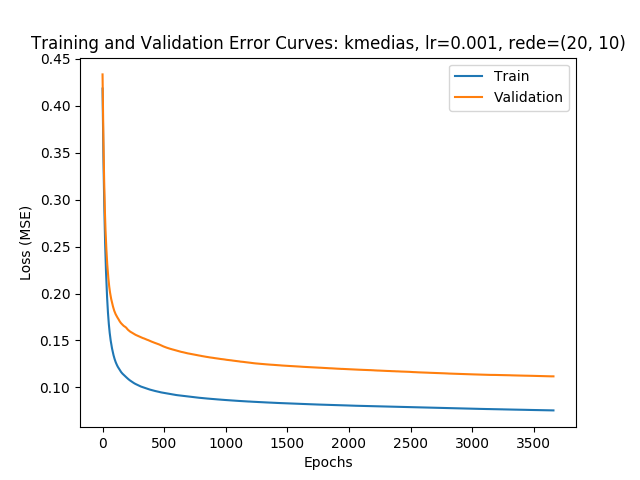

<IPython.core.display.Javascript object>


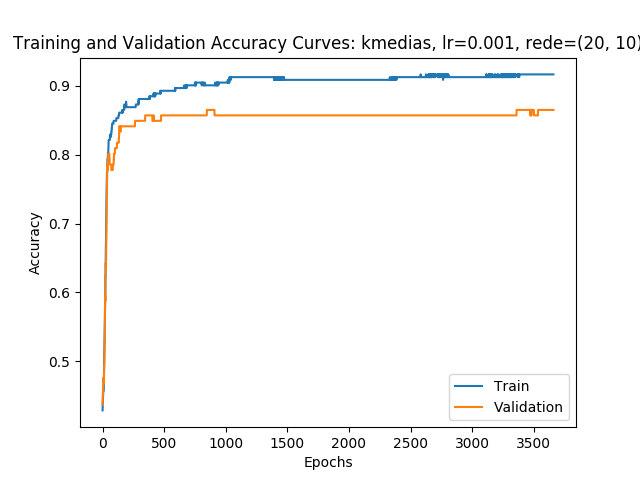

Matriz de confusão
[[1750  148]
 [   8   56]]

Train Loss:       0.0756
Validation Loss:  0.1118
Accuracy:         0.9205
MSE:              0.0795
AUROC:            0.9397


In [48]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [38]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.3985 - acc: 0.4921 - val_loss: 0.3333 - val_acc: 0.4841
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2788 - acc: 0.5079 - val_loss: 0.2272 - val_acc: 0.6429
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.1879 - acc: 0.7381 - val_loss: 0.1626 - val_acc: 0.7937
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1530 - acc: 0.7976 - val_loss: 0.1481 - val_acc: 0.8095
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1432 - acc: 0.8095 - val_loss: 0.1431 - val_acc: 0.8254
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1331 - acc: 0.8175 - val_loss: 0.1346 - val_acc: 0.8413
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1228 - acc: 0.8373 - val_loss: 0.1329 - val_acc: 0.8333
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1165 - acc

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1531 - val_acc: 0.8889
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1530 - val_acc: 0.8889
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1604 - val_acc: 0.8889
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1549 - val_acc: 0.8889
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1487 - val_acc: 0.8889
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1531 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1559 - val_acc: 0.8889
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1642 - val_acc: 0.8889
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1544 - val_acc: 0.8889
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1529 - val_acc: 0.8810
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1583 - val_acc: 0.8889
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1600 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8889
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1551 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8810 - val_loss: 0.1644 - val_acc: 0.8889
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1534 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8770 - val_loss: 0.1484 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8810 - val_loss: 0.1582 - val_acc: 0.8810
Epoch 450/2000
252/252 [==============================] - ETA: 0s - loss: 0.0996 - acc: 0.906 - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1558 - val_acc: 0.8810
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1585 - val_acc: 0.8889
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1565 - val_acc: 0.8889
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1552 - val_acc: 0.8889
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1537 - val_acc: 0.8810
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.877

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1574 - val_acc: 0.8810
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1521 - val_acc: 0.8810
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8810 - val_loss: 0.1600 - val_acc: 0.8889
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1588 - val_acc: 0.8810
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1566 - val_acc: 0.8810
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1586 - val_acc: 0.8889
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1583 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8730
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1572 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8849 - val_loss: 0.1580 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8730 - val_loss: 0.1592 - val_acc: 0.8810
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1575 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1548 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1533 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1621 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1528 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1584 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8810 - val_loss: 0.1560 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8849 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1587 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - ETA: 0s - loss: 0.0784 - acc: 0.937 - 0s - loss: 0.0893 - acc: 0.8810 - val_loss: 0.1561 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1594 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1648 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.881

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8810 - val_loss: 0.1528 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1579 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1577 - val_acc: 0.8730
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1591 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1528 - val_acc:

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1601 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8849 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8770 - val_loss: 0.1540 - val_acc: 0.8730
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8770 - val_loss: 0.1562 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1567 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1558 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1599 - val_acc:

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1516 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1630 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1532 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1559 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1632 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1538 - val_acc:

252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1552 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8770 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8770 - val_loss: 0.1600 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8849 - val_loss: 0.1598 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8770 - val_loss: 0.1549 - val_acc:

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8810 - val_loss: 0.1614 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1593 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1586 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8770 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8849 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1558 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8810 - val_loss: 0.1592 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1587 - val_acc:

252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1618 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1528 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8730 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1638 - val_acc: 0.8889
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1593 - val_acc:

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8849 - val_loss: 0.1561 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1597 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1575 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1526 - val_acc: 0.8810
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1572 - val_acc: 0.8810
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1612 - val_acc:

252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1572 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1569 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1589 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8810
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8849 - val_loss: 0.1593 - val_acc:

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.079650119691327681, 0.91335372075392929]


<IPython.core.display.Javascript object>


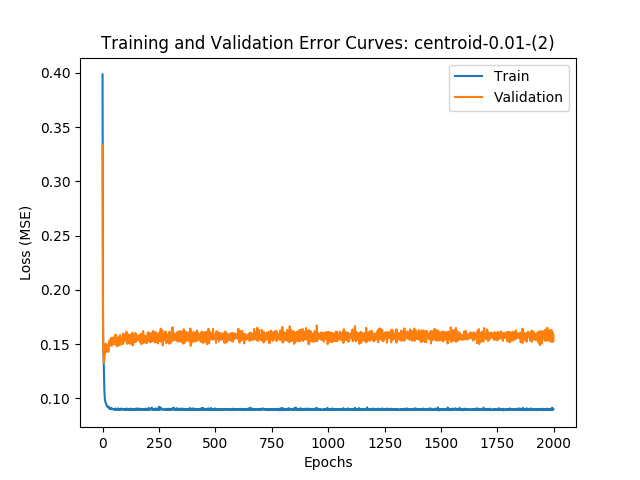

<IPython.core.display.Javascript object>


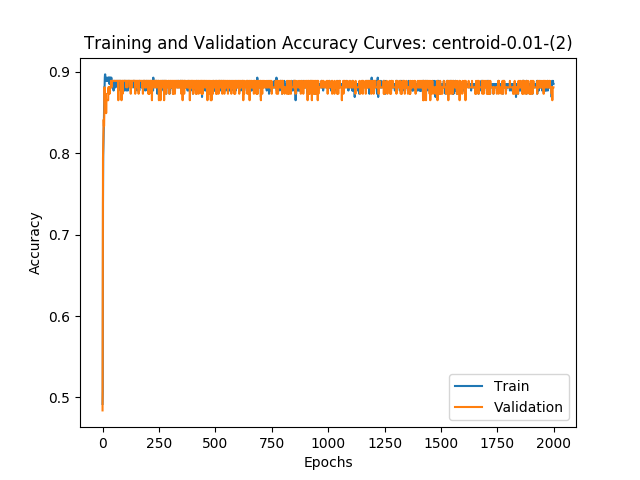

Matriz de confusão
[[1736  162]
 [   7   57]]

Train Loss:       0.1228
Validation Loss:  0.1329
Accuracy:         0.9139
MSE:              0.0861
AUROC:            0.9450


In [40]:
plot_training_error_curves(history, "centroid-0.01-(2)")
plot_training_acc_curves(history, "centroid-0.01-(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [41]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4484 - acc: 0.4683 - val_loss: 0.3372 - val_acc: 0.5635
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2772 - acc: 0.6389 - val_loss: 0.2569 - val_acc: 0.6984
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2030 - acc: 0.7381 - val_loss: 0.1945 - val_acc: 0.7619
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1571 - acc: 0.7937 - val_loss: 0.1539 - val_acc: 0.8016
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1342 - acc: 0.8294 - val_loss: 0.1293 - val_acc: 0.8413
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1171 - acc: 0.8651 - val_loss: 0.1287 - val_acc: 0.8571
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8611 - val_loss: 0.1409 - val_acc: 0.8571
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1039 - acc

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.9127
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.9127
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.0786 - val_acc: 0.9206
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0798 - val_acc: 0.9127
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.0782 - val_acc: 0.9206
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9087 - val_loss: 0.0823 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0774 - val_acc: 0.9206
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0865 - val_acc: 0.8968
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0755 - val_acc: 0.9206
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0747 - val_acc: 0.9127
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9087 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9048 - val_loss: 0.0746 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0853 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.0743 - val_acc: 0.9206
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0759 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0738 - val_acc: 0.9206
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9127 - val_loss: 0.0850 - val_acc: 0.8968
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0765 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0744 - val_acc: 0.9048
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9127 - val_loss: 0.0797 - val_acc: 0.8968
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0754 - val_acc: 0.9127
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0844 - val_acc: 0.8968
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0754 - val_acc: 0.9206
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.0737 - val_acc: 0.9206
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.0852 - val_acc: 0.8889
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9127 - val_loss: 0.0747 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9048 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0745 - val_acc: 0.9127
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.0745 - val_acc: 0.9127
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0795 - val_acc: 0.9048
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9127
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0752 - val_acc: 0.9048
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0818 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0745 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.0742 - val_acc: 0.9048
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9048 - val_loss: 0.0835 - val_acc: 0.9048
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0730 - val_acc: 0.9286
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0737 - val_acc: 0.9127
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0797 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9048 - val_loss: 0.0858 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9087 - val_loss: 0.0752 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0772 - val_acc: 0.9127
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9087 - val_loss: 0.0739 - val_acc: 0.9206
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0782 - val_acc: 0.8968
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0763 - val_acc: 0.9127
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0750 - val_acc: 0.9048
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0749 - val_acc: 0.9127
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.0924 - val_acc: 0.8968
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9127
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0773 - val_acc: 0.9048
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.0788 - val_acc: 0.9127
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0742 - val_acc: 0.9206
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.0803 - val_acc: 0.8968
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0743 - val_acc:

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0790 - val_acc: 0.8968
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0731 - val_acc: 0.9206
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0762 - val_acc: 0.9127
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0778 - val_acc: 0.8968
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9087 - val_loss: 0.0734 - val_acc: 0.9206
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0753 - val_acc: 0.9048
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9087 - val_loss: 0.0744 - val_acc:

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0744 - val_acc: 0.9206
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0740 - val_acc: 0.9127
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0762 - val_acc: 0.8968
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0742 - val_acc: 0.9206
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.0781 - val_acc: 0.9048
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9087 - val_loss: 0.0763 - val_acc: 0.8968
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.0753 - val_acc:

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0733 - val_acc: 0.9206
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0774 - val_acc: 0.9048
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0767 - val_acc: 0.9048
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9087 - val_loss: 0.0749 - val_acc: 0.9048
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9127 - val_loss: 0.0809 - val_acc: 0.8968
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9087 - val_loss: 0.0760 - val_acc: 0.9048
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.0758 - val_acc: 0.9127
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.0835 - val_acc:

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9127 - val_loss: 0.0753 - val_acc: 0.9206
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0760 - val_acc: 0.9048
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9127 - val_loss: 0.0735 - val_acc: 0.9127
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9127 - val_loss: 0.0762 - val_acc: 0.9127
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9127 - val_loss: 0.0876 - val_acc:

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9087 - val_loss: 0.0806 - val_acc: 0.8968
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0737 - val_acc: 0.9127
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9048 - val_loss: 0.0748 - val_acc: 0.9127
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0779 - val_acc: 0.8968
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0751 - val_acc: 0.9127
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.0741 - val_acc: 0.9127
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9087 - val_loss: 0.0760 - val_acc:

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0740 - val_acc: 0.9206
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0884 - val_acc: 0.8968
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.0732 - val_acc: 0.9206
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0777 - val_acc: 0.9048
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9048 - val_loss: 0.0758 - val_acc: 0.9127
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.0819 - val_acc: 0.8968
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0764 - val_acc: 0.9048
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9127 - val_loss: 0.0731 - val_acc:

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0744 - val_acc: 0.9206
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9048
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9127 - val_loss: 0.0770 - val_acc: 0.9048
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0758 - val_acc: 0.9206
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9087 - val_loss: 0.0759 - val_acc: 0.9048
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9087 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0775 - val_acc: 0.8968
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.0737 - val_acc:

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096324953433813545, 0.89500509677920015]


<IPython.core.display.Javascript object>


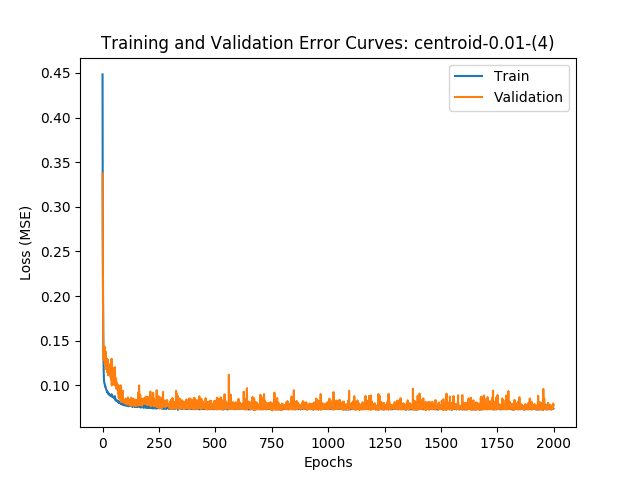

<IPython.core.display.Javascript object>


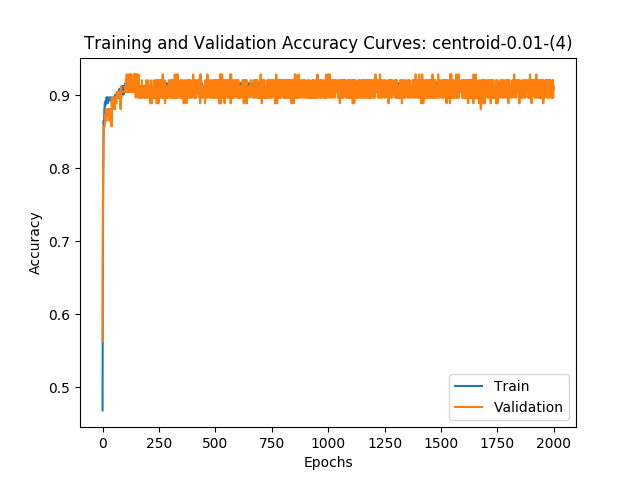

Matriz de confusão
[[1700  198]
 [   8   56]]

Train Loss:       0.0745
Validation Loss:  0.0719
Accuracy:         0.8950
MSE:              0.1050
AUROC:            0.9276


In [43]:
plot_training_error_curves(history, "centroid-0.01-(4)")
plot_training_acc_curves(history, "centroid-0.01-(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))